# Linear Regression
BASELINE MODEL

Idea: Load Targets (1000px images of MRT AT MagVel), Load X (5 values per timestep). 
Visaulize some random Targets with their corresponding X. 

Develop separate Linear Regression Models for prediction of MRT AT and MagVel based on 5 Values. 

Showcase the shortcomings.  


Update: 22/04/2025: 

- Wake Mask: for convective variables MagVel and Air temp. 
- Wake zones = regions sheltered from wind. 
- Random Forest should be able to better predict reduced windspeed in wakezones, and modified air temprtaure due to reduced convecitve cooling/heating in the wake. 

For Magvel: 
- Wake Mask

For Air Temp
- Wake Mask + Inverse distancemask. 

For MRT:
- Inverse distance mask: 
- Proximity to buildings: gain of radiation from solar load, and also surface temprature of buildings. 


--> implemnentation of using the wakemask led to the case that the model takes longer and performs much worse in 5 fold crossval. 

--> Duplciating rare 5 value configs test: 


In [1]:
import os
import random
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [2]:


# ==============================
# Configuration
# ==============================

CSV_DIR = "../data/X"
IMG_DIR = "../data/Y"
BUILDING_MASK_PATH = "../RawSimOutputData/6Bldgs/BldgMask150cm-BlackWhiteWithAntiAlias.png"
DILATION_PIXELS = 2

# ==============================
# Helper Functions
# ==============================

def parse_image_metadata(filename):
    pattern = r"(?P<date>\d{4}-\d{2}-\d{2})_6Bldgs_(?P<type>AT|MRT|MagVel)_(?P<range>[0-9\-]+(?:K|ms))_(?P<hour>\d+)\.png"
    match = re.match(pattern, os.path.basename(filename))
    if not match:
        raise ValueError(f"Filename not in expected format: {filename}")
    
    value_range = match.group("range")
    nums = re.findall(r"\d+", value_range)

    return {
        "date": match.group("date"),
        "type": match.group("type"),
        "range": value_range,
        "hour": int(match.group("hour")),
        "value_min": float(nums[0]),
        "value_max": float(nums[1])
    }

def load_clean_building_mask(mask_path, dilation=2):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Could not load building mask: {mask_path}")
    
    binary_mask = (mask == 0).astype(np.uint8)

    if dilation > 0:
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.dilate(binary_mask, kernel, iterations=dilation)

    return binary_mask.astype(bool)

def load_image_with_building_mask(image_path, return_metadata=False, mask_path=BUILDING_MASK_PATH, dilation=DILATION_PIXELS):
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load and convert to grayscale
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"cv2 failed to load image: {image_path}")
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # Parse metadata and scale values
    meta = parse_image_metadata(image_path)
    img_scaled = meta["value_min"] + (img_gray / 255.0) * (meta["value_max"] - meta["value_min"])

    # Load and apply building mask
    bldg_mask = load_clean_building_mask(mask_path, dilation=dilation)
    if bldg_mask.shape != img_scaled.shape:
        raise ValueError("Mask and image dimensions do not match")

    img_scaled[bldg_mask] = np.nan

    return (img_scaled, meta) if return_metadata else img_scaled

# Load Sample Training Data

📄 Random sample selected: 5values_2024-03-24_04.csv

📊 5 input values:
Hour                         4.000000
Windspeed (m/s)              1.388889
Wind Direction (deg)        92.000000
Solar Irradiance (W/m2)      0.000000
Air Temperature (K)        287.450000


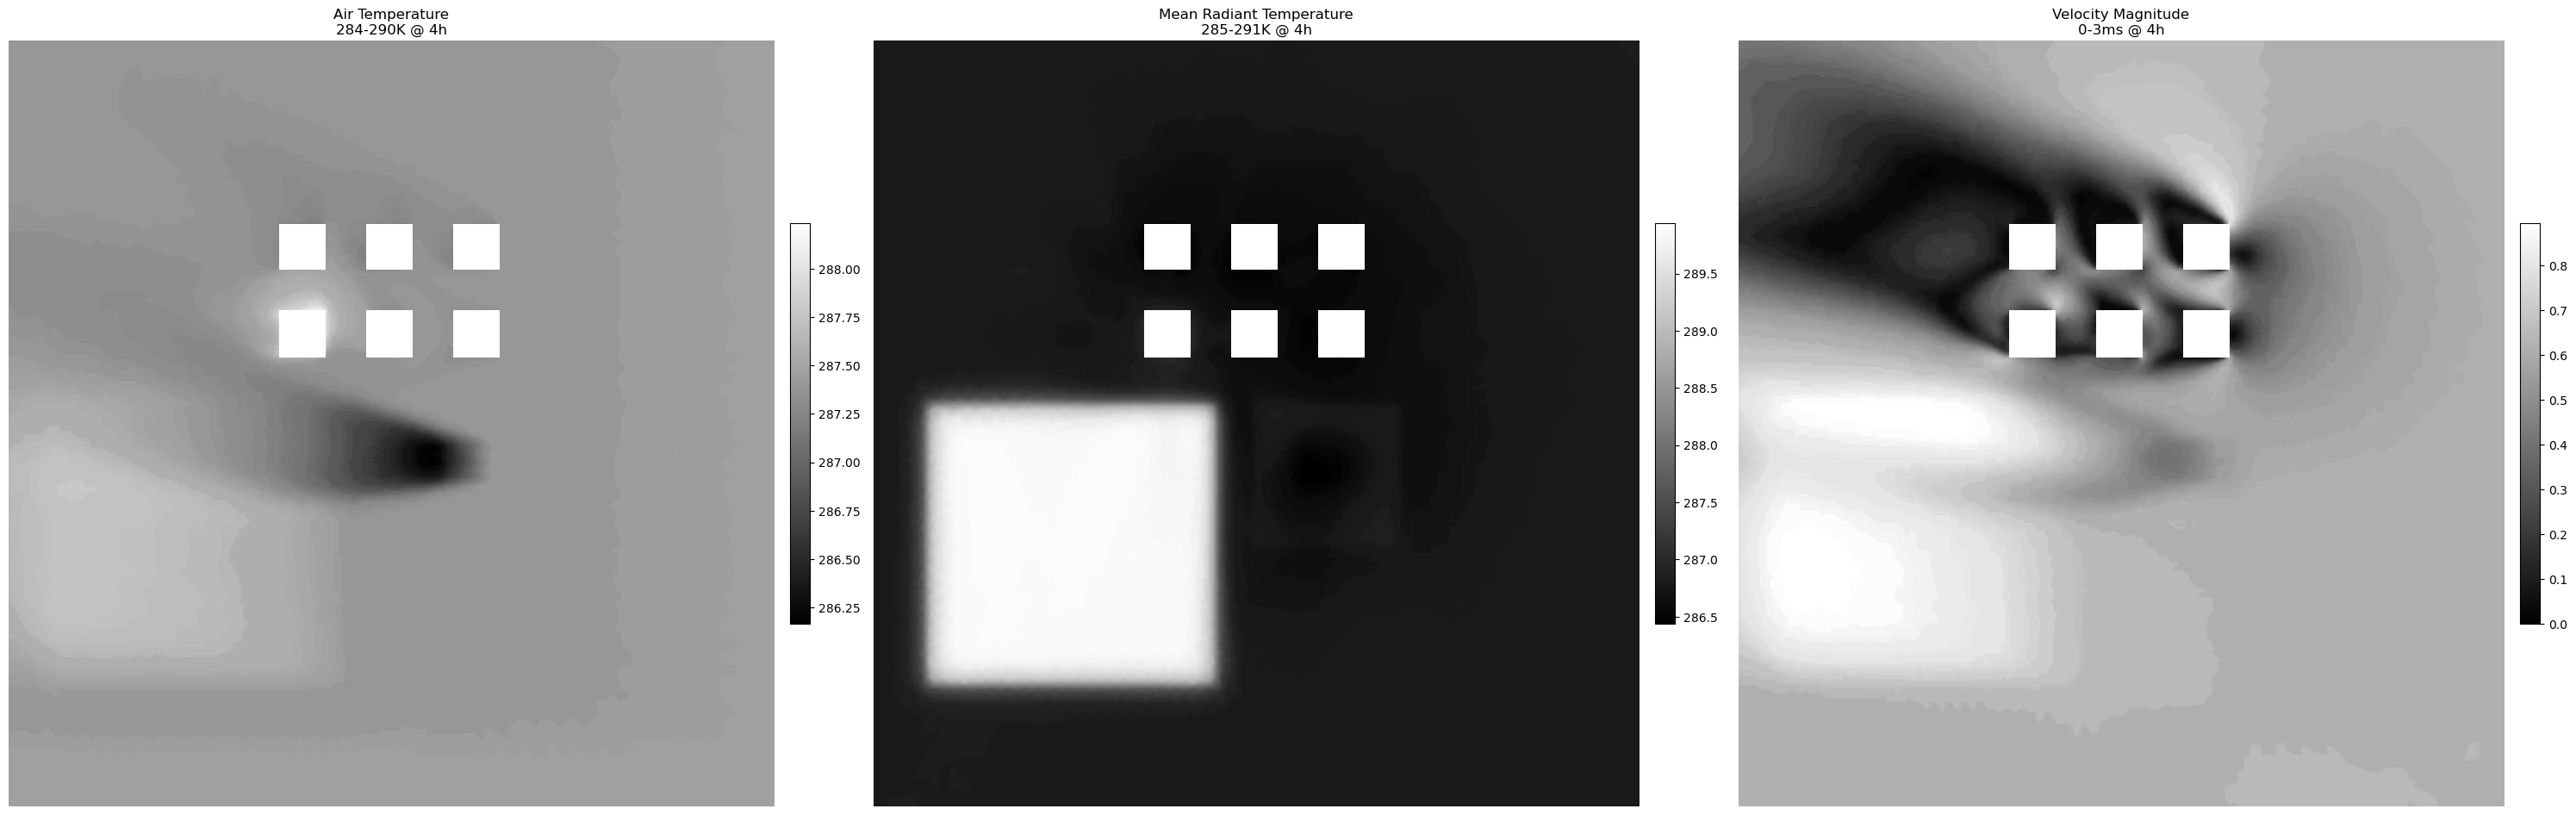

In [3]:
# Load random CSV sample
csv_files = [f for f in os.listdir(CSV_DIR) if f.startswith("5values_") and f.endswith(".csv")]
chosen_csv = random.choice(csv_files)
csv_path = os.path.join(CSV_DIR, chosen_csv)

# Extract date and hour from filename
parts = chosen_csv.split("_")
date_str = parts[1]
hour = int(parts[2].split(".")[0])
print(f"📄 Random sample selected: {chosen_csv}")

# Load and print 5 input values
df = pd.read_csv(csv_path)
print("\n📊 5 input values:")
print(df.iloc[0].to_string(index=True))


#------- Load Images
image_tags = {
    "AT": "Air Temperature",
    "MRT": "Mean Radiant Temperature",
    "MagVel": "Velocity Magnitude"
}

images = {}
metas = {}

for tag, label in image_tags.items():
    matches = [f for f in os.listdir(IMG_DIR) if f.startswith(date_str) and tag in f and f.endswith(f"_{hour}.png")]
    if matches:
        image_path = os.path.join(IMG_DIR, matches[0])
        img, meta = load_image_with_building_mask(image_path, return_metadata=True)
        images[label] = img
        metas[label] = meta
    else:
        print(f"⚠️ No image found for {label} at {date_str}, hour {hour}")

# Plot the images
if not images:
    print(f"🚫 No images found for any tag at {date_str}, hour {hour}")
else:
    fig, axs = plt.subplots(1, len(images), figsize=(10 * len(images), 10))

    if len(images) == 1:
        axs = [axs]

    for i, (label, img) in enumerate(images.items()):
        im = axs[i].imshow(img, cmap="gray")
        cbar = plt.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.025, pad=0.02)
        axs[i].set_title(f"{label}\n{metas[label]['range']} @ {metas[label]['hour']}h")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()




# Analyze available Training Data 

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === CONFIG ===
CSV_DIR = "../data/X"
IMG_DIR = "../data/Y"
TARGET_TYPES = ["MRT", "MagVel", "AT"]  # Now includes Air Temperature

# === STORAGE ===
X_features = []
Y_images = {tt: [] for tt in TARGET_TYPES}
PCA_models = {}
Y_pca_data = {}

# === LOOP THROUGH SAMPLES ===
for csv_file in sorted(os.listdir(CSV_DIR)):
    if not csv_file.startswith("5values_") or not csv_file.endswith(".csv"):
        continue

    date = csv_file.split("_")[1]
    hour = int(csv_file.split("_")[2].split(".")[0])
    csv_path = os.path.join(CSV_DIR, csv_file)

    # Load input features
    df = pd.read_csv(csv_path)
    features = df.iloc[0][["Hour", "Windspeed (m/s)", "Wind Direction (deg)", "Solar Irradiance (W/m2)", "Air Temperature (K)"]].values

    # Check if all target images exist
    image_paths = {}
    for target in TARGET_TYPES:
        pattern = f"{date}_6Bldgs_{target}_"
        matches = [f for f in os.listdir(IMG_DIR) if f.startswith(pattern) and f.endswith(f"_{hour}.png")]
        if not matches:
            break
        image_paths[target] = os.path.join(IMG_DIR, matches[0])
    else:
        try:
            X_features.append(features)
            for target in TARGET_TYPES:
                img, meta = load_image_with_building_mask(image_paths[target], return_metadata=True)
                if np.isnan(img).all():
                    raise ValueError("Image is all NaNs")
                flat_img = img.flatten()
                flat_img[np.isnan(flat_img)] = 0  # Fill for PCA
                Y_images[target].append(flat_img)
        except Exception as e:
            print(f"Error processing {date} {hour}: {e}")
            continue

# === CONVERT TO ARRAYS ===
X_features = np.array(X_features)
for target in TARGET_TYPES:
    Y_images[target] = np.array(Y_images[target])




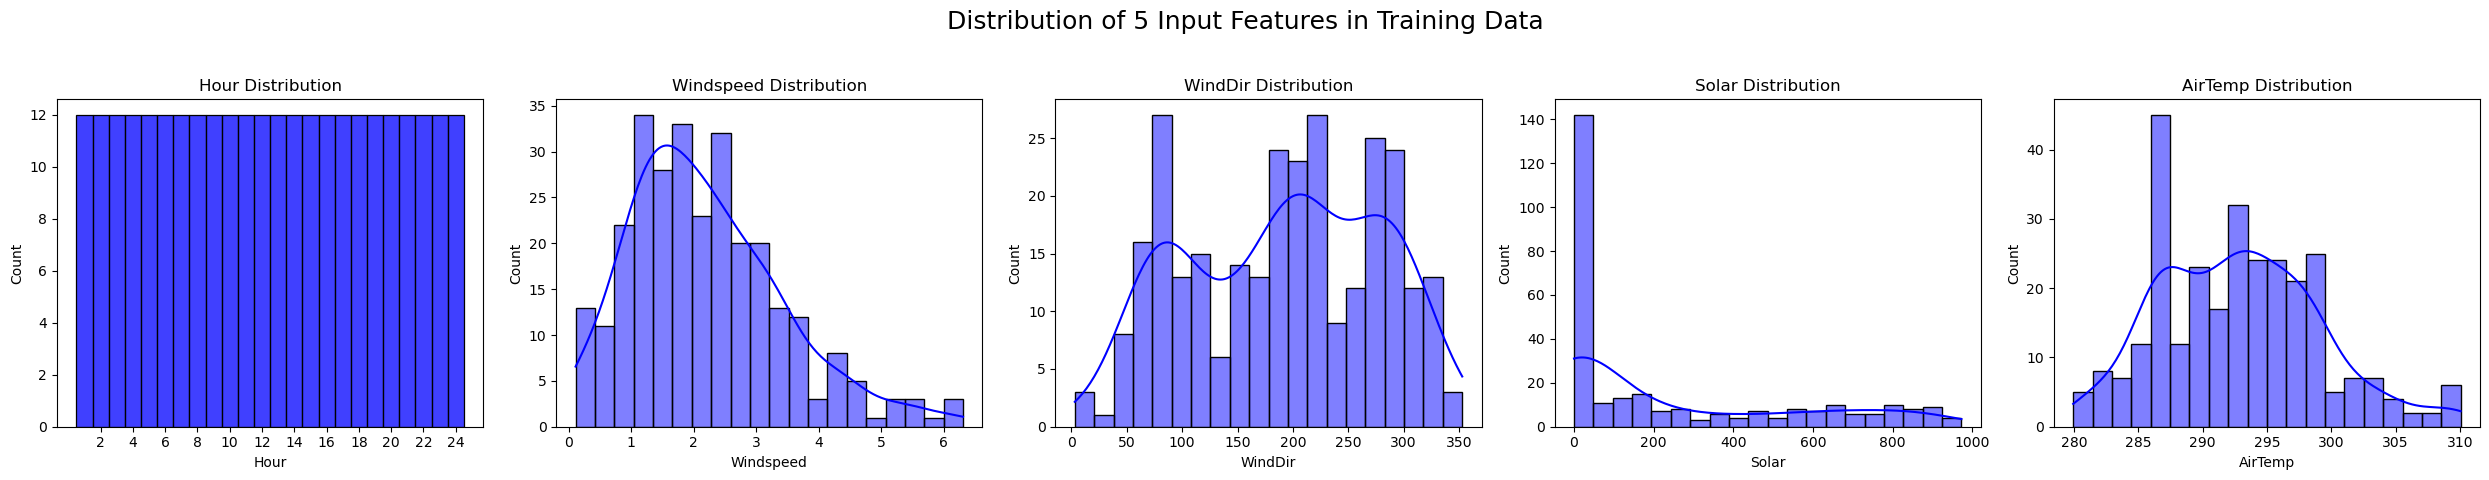

In [5]:
# Balance Data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming X_features_used is your training dataset
df_features = pd.DataFrame(X_features, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# Plot distributions with KDE overlay
features = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for idx, feat in enumerate(features):
    if feat == "Hour":
        sns.histplot(df_features[feat], bins=np.arange(1, 26), ax=axs[idx], kde=False, color="blue", edgecolor='black', discrete=True)
        axs[idx].set_xticks(np.arange(2, 25, 2))
    else:
        sns.histplot(df_features[feat], bins=20, kde=True, ax=axs[idx], color='blue', edgecolor='black')

    
    # sns.histplot(df_features[feat], bins=20, kde=True, ax=axs[idx], color='skyblue', edgecolor='black')
    axs[idx].set_title(f"{feat} Distribution")
    axs[idx].set_xlabel(feat)
    axs[idx].set_ylabel("Count")

plt.suptitle("Distribution of 5 Input Features in Training Data", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Input Features')

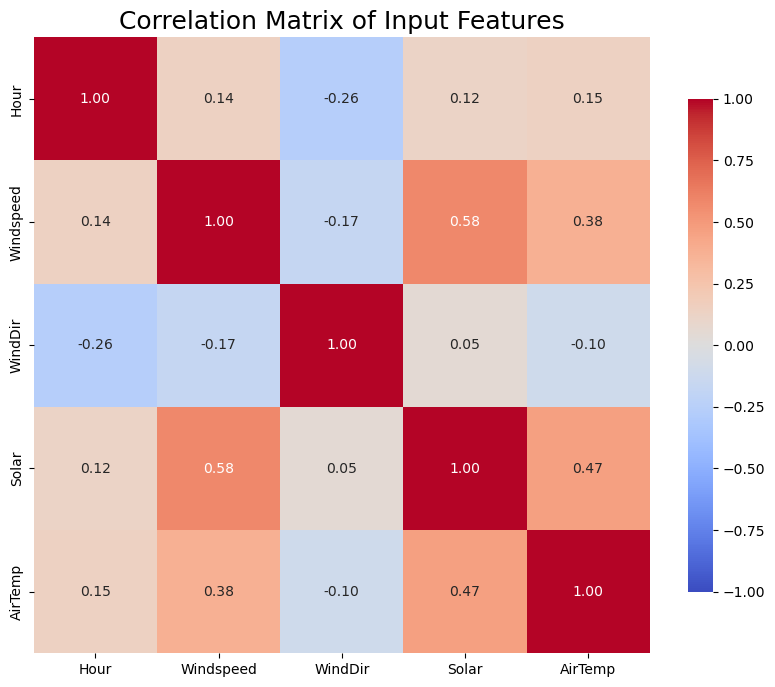

In [6]:
# plot correalation of X
corr = df_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1 , square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Matrix of Input Features", fontsize=18)



# Check distribution of Training data And Rebalance by duplicating

--> problem: theres  a skew towards certain conditions in the 5 values used for training. 
Some combinations especially for windspeed and solar radiation are overrepresented. 

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# --- ORIGINAL DATA ---
df_features_all = pd.DataFrame(X_features, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# --- SPLIT DATA FIRST ---
X_train_orig, X_test, train_indices, test_indices = train_test_split(
    X_features, range(len(X_features)), test_size=0.15, random_state=42, shuffle=True
)
df_features_train_before = pd.DataFrame(X_train_orig, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# --- BALANCING PROCESS ON TRAINING DATA ONLY ---
combined_data = df_features_train_before.copy()
combined_data["target_index"] = list(range(len(combined_data)))

# Bin by Windspeed, Solar, WindDir (3x3x3 bins)
combined_data["wind_bin"] = pd.cut(combined_data["Windspeed"], bins=5) #splits data into 5 bins for different windspeed ranges. 
combined_data["solar_bin"] = pd.cut(combined_data["Solar"], bins=5) 
combined_data["winddir_bin"] = pd.cut(combined_data["WindDir"], bins=5)


# --- BALANCE DATASET ---
grouped = combined_data.groupby(["wind_bin", "solar_bin", "winddir_bin"]).size().reset_index(name='count')
valid_bins = grouped[grouped['count'] > 0]
percentile_threshold = int(np.ceil(valid_bins['count'].quantile(0.8)))
print(f"80th percentile threshold (rounded up): {percentile_threshold}")

balanced_indices = []

# --- Inspect bin counts ---
print("\n--- Bin Statistics Before Balancing ---")
print(f"Total number of bins: {len(grouped)}")
print(f"Number of non-empty bins: {len(valid_bins)}")
print(f"Bin counts (min/median/max): {valid_bins['count'].min()} / {valid_bins['count'].median()} / {valid_bins['count'].max()}")
print(f"80th percentile threshold for upsampling: {percentile_threshold}\n")

for _, row in valid_bins.iterrows():
    mask = (combined_data["wind_bin"] == row["wind_bin"]) & \
           (combined_data["solar_bin"] == row["solar_bin"]) & \
           (combined_data["winddir_bin"] == row["winddir_bin"])

    subset = combined_data[mask]
    if row["count"] < percentile_threshold:
        upsampled = resample(subset, replace=True, n_samples=int(percentile_threshold), random_state=42)
        balanced_indices.extend(upsampled["target_index"].tolist())
    else:
        balanced_indices.extend(subset["target_index"].tolist())

# Rebuild balanced training data
X_train_balanced = X_train_orig[balanced_indices]
df_features_train_after = pd.DataFrame(X_train_balanced, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

print(f"✅ Balanced training dataset created: {len(X_train_balanced)} samples (original training: {len(X_train_orig)})")



80th percentile threshold (rounded up): 7

--- Bin Statistics Before Balancing ---
Total number of bins: 125
Number of non-empty bins: 54
Bin counts (min/median/max): 1 / 2.0 / 24
80th percentile threshold for upsampling: 7

✅ Balanced training dataset created: 449 samples (original training: 244)


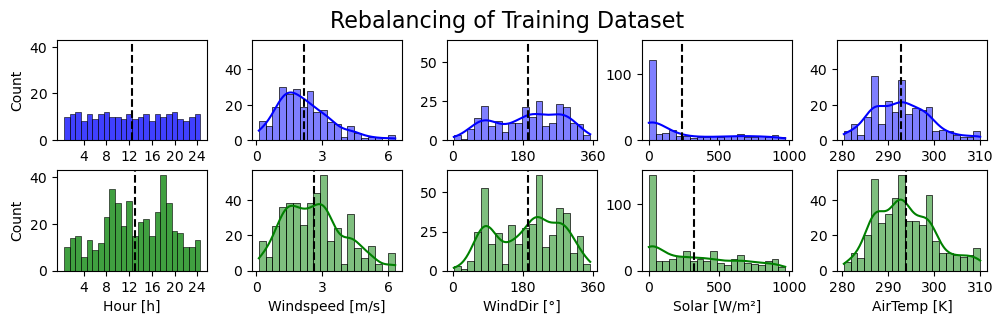

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- PLOT BEFORE & AFTER BALANCING ON TRAINING DATA ---
features = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
feature_units = {
    "Hour": "Hour [h]",
    "Windspeed": "Windspeed [m/s]",
    "WindDir": "WindDir [°]",
    "Solar": "Solar [W/m²]",
    "AirTemp": "AirTemp [K]"
}

fig, axs = plt.subplots(2, 5, figsize=(12, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, feat in enumerate(features):
    # --- Plot Before Balancing ---
    if feat == "Hour":
        hist_b = sns.histplot(df_features_train_before[feat], bins=np.arange(1, 26), ax=axs[0, idx], kde=False, color="blue", discrete=True)
    else:
        hist_b = sns.histplot(df_features_train_before[feat], bins=20, ax=axs[0, idx], kde=True, color="blue")

    mean_b = df_features_train_before[feat].mean()
    axs[0, idx].axvline(mean_b, color="black", linestyle="--", linewidth=1.5)

    # --- Plot After Balancing ---
    if feat == "Hour":
        hist_a = sns.histplot(df_features_train_after[feat], bins=np.arange(1, 26), ax=axs[1, idx], kde=False, color="green", discrete=True)
    else:
        hist_a = sns.histplot(df_features_train_after[feat], bins=20, ax=axs[1, idx], kde=True, color="green")

    mean_a = df_features_train_after[feat].mean()
    axs[1, idx].axvline(mean_a, color="black", linestyle="--", linewidth=1.5)

    # --- Set shared y-axis limits ---
    shared_ymax = max(hist_b.get_ylim()[1], hist_a.get_ylim()[1])
    axs[0, idx].set_ylim(0, shared_ymax)
    axs[1, idx].set_ylim(0, shared_ymax)

    # --- Adjust x-axis ticks ---
    if feat == "Hour":
        tick_positions = np.arange(4, 25, 4)
        axs[0, idx].set_xticks(tick_positions)
        axs[1, idx].set_xticks(tick_positions)
    elif feat == "Windspeed":
        axs[0, idx].set_xticks([0, 3, 6])
        axs[1, idx].set_xticks([0, 3, 6])
    elif feat == "WindDir":
        axs[0, idx].set_xticks([0, 180, 360])
        axs[1, idx].set_xticks([0, 180, 360])
    elif feat == "AirTemp":
        axs[0, idx].set_xticks([280, 290, 300, 310])
        axs[1, idx].set_xticks([280, 290, 300, 310])

    # --- Add x-axis labels with units only to bottom row ---
    axs[1, idx].set_xlabel(feature_units[feat])
    axs[0, idx].set_xlabel("")

    # --- Remove y-axis labels except first column ---
    if idx != 0:
        axs[0, idx].set_ylabel("")
        axs[1, idx].set_ylabel("")

# --- Only first column keeps y-axis label ---
axs[0, 0].set_ylabel("Count")
axs[1, 0].set_ylabel("Count")

plt.suptitle("Rebalancing of Training Dataset", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# PCA Compression of Y Images

In [8]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Target explained variance threshold and max component cap
EXPLAINED_VARIANCE_THRESHOLD = 0.9999  # 99.99%
MAX_COMPONENTS = 30  # Cap components

# --- Convert indices relative to original dataset ---
balanced_indices_global = [train_indices[i] for i in balanced_indices]

# --- Prepare Balanced and Unbalanced Y_images ---
Y_images_bal = {tt: Y_images[tt][balanced_indices_global] for tt in TARGET_TYPES}
Y_images_unbal = {tt: Y_images[tt][train_indices] for tt in TARGET_TYPES}

# --- PCA Storage ---
Y_pca_data_bal = {}
Y_pca_data_unbal = {}
PCA_models_bal = {}
PCA_models_unbal = {}
n_components_dict_bal = {}
n_components_dict_unbal = {}
PCA_full_models_bal = {}
PCA_full_models_unbal = {}

# --- Fit PCA with variance threshold and cap ---
for target in TARGET_TYPES:
    # --- PCA for Balanced Data ---
    pca_bal_full = PCA(n_components=EXPLAINED_VARIANCE_THRESHOLD, svd_solver='auto')
    Y_pca_data_bal_full = pca_bal_full.fit_transform(Y_images_bal[target])
    n_used_bal = min(pca_bal_full.n_components_, MAX_COMPONENTS)

    pca_bal_capped = PCA(n_components=n_used_bal, svd_solver='randomized')
    Y_pca_data_bal[target] = pca_bal_capped.fit_transform(Y_images_bal[target])
    PCA_models_bal[target] = pca_bal_capped
    PCA_full_models_bal[target] = pca_bal_full
    n_components_dict_bal[target] = n_used_bal

    # --- Check explained variance ---
    explained_var_bal = np.sum(pca_bal_full.explained_variance_ratio_[:n_used_bal])
    if explained_var_bal < EXPLAINED_VARIANCE_THRESHOLD:
        print(f"⚠️ Balanced PCA for {target}: Only {explained_var_bal:.5f} explained with {n_used_bal} components.")

    # --- PCA for Unbalanced Data ---
    pca_unbal_full = PCA(n_components=EXPLAINED_VARIANCE_THRESHOLD, svd_solver='auto')
    Y_pca_data_unbal_full = pca_unbal_full.fit_transform(Y_images_unbal[target])
    n_used_unbal = min(pca_unbal_full.n_components_, MAX_COMPONENTS)

    pca_unbal_capped = PCA(n_components=n_used_unbal, svd_solver='randomized')
    Y_pca_data_unbal[target] = pca_unbal_capped.fit_transform(Y_images_unbal[target])
    PCA_models_unbal[target] = pca_unbal_capped
    PCA_full_models_unbal[target] = pca_unbal_full
    n_components_dict_unbal[target] = n_used_unbal

    # --- Check explained variance ---
    explained_var_unbal = np.sum(pca_unbal_full.explained_variance_ratio_[:n_used_unbal])
    if explained_var_unbal < EXPLAINED_VARIANCE_THRESHOLD:
        print(f"⚠️ Unbalanced PCA for {target}: Only {explained_var_unbal:.5f} explained with {n_used_unbal} components.")

    print(f"\nPCA complete for {target}")
    print(f"Balanced Image shape: {Y_images_bal[target].shape}")
    print(f"PCA shape (Balanced): {Y_pca_data_bal[target].shape} | Components used: {n_used_bal}")
    print(f"Unbalanced Image shape: {Y_images_unbal[target].shape}")
    print(f"PCA shape (Unbalanced): {Y_pca_data_unbal[target].shape} | Components used: {n_used_unbal}")

# --- PCA Transform Test Data ---
Y_pca_data_test_bal = {}
Y_pca_data_test_unbal = {}

for target in TARGET_TYPES:
    Y_test_images = Y_images[target][test_indices]

    # Transform using balanced PCA
    Y_pca_data_test_bal[target] = PCA_models_bal[target].transform(Y_test_images)

    # Transform using unbalanced PCA
    Y_pca_data_test_unbal[target] = PCA_models_unbal[target].transform(Y_test_images)

    print(f"\nTest set PCA-transformed for {target}:")
    print(f" - Shape (Balanced PCA):   {Y_pca_data_test_bal[target].shape}")
    print(f" - Shape (Unbalanced PCA): {Y_pca_data_test_unbal[target].shape}")


PCA complete for MRT
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 19) | Components used: 19
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 19) | Components used: 19
⚠️ Balanced PCA for MagVel: Only 0.99906 explained with 30 components.
⚠️ Unbalanced PCA for MagVel: Only 0.99840 explained with 30 components.

PCA complete for MagVel
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 30) | Components used: 30
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 30) | Components used: 30

PCA complete for AT
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 7) | Components used: 7
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 8) | Components used: 8

Test set PCA-transformed for MRT:
 - Shape (Balanced PCA):   (44, 19)
 - Shape (Unbalanced PCA): (44, 19)

Test set PCA-transformed for MagVel:
 - Shape (Balanced PCA):   (44, 30)
 - Shape (Unbalanced PCA): (44, 30)

Test set PCA-tra

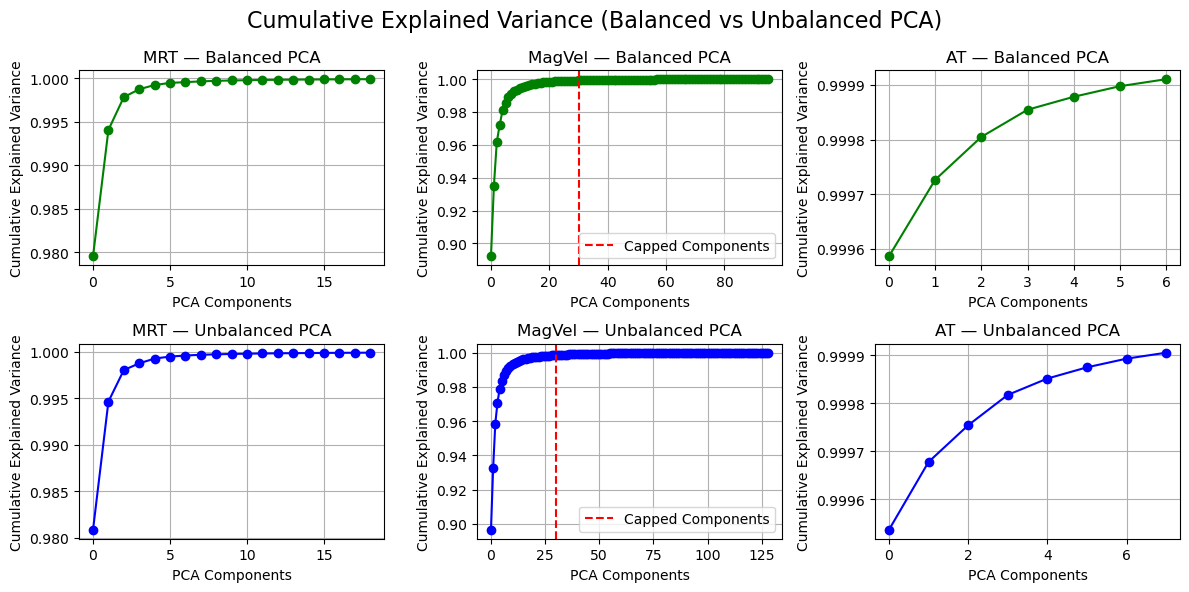

In [15]:
# --- Plot Explained Variance Ratios for Both ---
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for idx, target in enumerate(TARGET_TYPES):
    # Balanced PCA plot
    pca_bal_full = PCA_full_models_bal[target]
    n_used_bal = n_components_dict_bal[target]
    axs[0, idx].plot(np.cumsum(pca_bal_full.explained_variance_ratio_), marker="o", color="green")
    
    # Show cap line only if capped
    if pca_bal_full.n_components_ > MAX_COMPONENTS:
        axs[0, idx].axvline(n_used_bal, color="red", linestyle="--", label="Capped Components")
        axs[0, idx].legend()

    axs[0, idx].set_title(f"{target} — Balanced PCA")
    axs[0, idx].set_xlabel("PCA Components")
    axs[0, idx].set_ylabel("Cumulative Explained Variance")
    axs[0, idx].grid(True)

    # Unbalanced PCA plot
    pca_unbal_full = PCA_full_models_unbal[target]
    n_used_unbal = n_components_dict_unbal[target]
    axs[1, idx].plot(np.cumsum(pca_unbal_full.explained_variance_ratio_), marker="o", color="blue")
    
    if pca_unbal_full.n_components_ > MAX_COMPONENTS:
        axs[1, idx].axvline(n_used_unbal, color="red", linestyle="--", label="Capped Components")
        axs[1, idx].legend()

    axs[1, idx].set_title(f"{target} — Unbalanced PCA")
    axs[1, idx].set_xlabel("PCA Components")
    axs[1, idx].set_ylabel("Cumulative Explained Variance")
    axs[1, idx].grid(True)

plt.suptitle("Cumulative Explained Variance (Balanced vs Unbalanced PCA)", fontsize=16)
plt.tight_layout()
plt.show()



# Crossvalidation to find optimal Hyperparams for RFs 

In [16]:
# === STORAGE FOR MODELS AND RESULTS ===
rf_models = {}
rf_results = {}

# === HYPERPARAMETER GRID ===
param_grid = {
    "estimator__n_estimators": [200, 250, 300],
    "estimator__max_depth": [10, 20, 30],
    "estimator__min_samples_split": [2,3, 4],
}

# === TOGGLE BETWEEN BALANCED AND UNBALANCED ===
use_balanced = True  # 🔄 Set this to False for unbalanced run

# === PICK DATA ACCORDINGLY ===
X_train_full = X_train_balanced if use_balanced else X_train_orig
PCA_models_current = PCA_models_bal if use_balanced else PCA_models_unbal
Y_pca_data_current = Y_pca_data_bal if use_balanced else Y_pca_data_unbal
Y_pca_data_test_current = Y_pca_data_test_bal if use_balanced else Y_pca_data_test_unbal

print(f"\n🔄 Using {'BALANCED' if use_balanced else 'UNBALANCED'} training dataset.")

# === LOOP THROUGH TARGETS ===
for target in ["MRT", "MagVel", "AT"]:
    print(f"\nTraining Random Forest with GridSearchCV for {target}...")

    y_target_train = Y_pca_data_current[target]
    y_target_test = Y_pca_data_test_current[target]
    pca_model = PCA_models_current[target]

    # --- INPUT ADJUSTMENT ---
    X_target_train = X_train_full.copy()
    feature_names = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]

    if target == "AT" and use_balanced:
        X_target_train[:, -1] += np.random.normal(0, 0.5, size=X_target_train.shape[0])
        print('🔹 AT target noise injected')

    print(f"Training on {len(X_target_train)} samples | Evaluating on {len(X_test)} test samples")

    # Define base estimator
    base_rf = RandomForestRegressor(n_jobs=1, random_state=42)
    multi_rf = MultiOutputRegressor(base_rf, n_jobs=1)

    # GridSearchCV with 5-fold CV on training set
    grid = GridSearchCV(
        multi_rf,
        param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        verbose=2,
        n_jobs=50
    )

    # Fit model
    grid.fit(X_target_train, y_target_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)  # Evaluate on consistent global test set

    # Inverse PCA to full image
    y_true_recon = pca_model.inverse_transform(y_target_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    # Apply mask
    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # Metrics
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    # Store results
    rf_models[target] = best_model
    rf_results[target] = {
        "X_test": X_test,
        "y_test": y_target_test,
        "y_pred": y_pred,
        "flat_true": flat_true,
        "flat_pred": flat_pred,
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "best_params": grid.best_params_,
        "feature_names": feature_names
    }

    print(f"Best params for {target}: {grid.best_params_}")
    print(f"Metrics in physical units:")
    print(f"   R² Score:  {r2:.3f}")
    print(f"   MAE:       {mae:.3f}")
    print(f"   RMSE:      {rmse:.3f}")

# === FEATURE IMPORTANCE ===
for target in ["MRT", "MagVel", "AT"]:
    importances = rf_models[target].estimators_[0].feature_importances_
    feature_names = rf_results[target]['feature_names']
    print(f"\nFeature importances for {target}:")
    for feat, imp in zip(feature_names, importances):
        print(f"{feat}: {imp:.3f}")


🔄 Using BALANCED training dataset.

Training Random Forest with GridSearchCV for MRT...
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for MRT: {'estimator__max_depth': 20, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 250}
Metrics in physical units:
   R² Score:  0.867
   MAE:       1.294
   RMSE:      1.995

Training Random Forest with GridSearchCV for MagVel...
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for MagVel: {'estimator__max_depth': 30, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300}
Metrics in physical units:
   R² Score:  0.961
   MAE:       0.137
   RMSE:      0.222

Training Random Forest with GridSearchCV for AT...
🔹 AT target noise injected
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params

# Gradboosting Model for worst Variable: MRT

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# === GRADIENT BOOSTING Grid Search for MRT ===
print(f"\n🌟 GridSearchCV for Gradient Boosting MRT...")

# Balanced data
X_mrt_train = X_train_full.copy()
y_mrt_train = Y_pca_data_current["MRT"]
y_mrt_test = Y_pca_data_test_current["MRT"]
pca_model = PCA_models_current["MRT"]

# === Define Grid ===
gb_param_grid = {
    "estimator__n_estimators": [170, 200, 230],
    "estimator__max_depth": [3,5,7],
    "estimator__learning_rate": [0.05, 0.1]
}

# Base GB model
gb_base = GradientBoostingRegressor(random_state=42)
gb_multi = MultiOutputRegressor(gb_base, n_jobs=1)

# Grid Search
gb_grid = GridSearchCV(
    gb_multi,
    gb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    n_jobs=20
)

# Fit Grid
gb_grid.fit(X_mrt_train, y_mrt_train)
best_gb_model = gb_grid.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

# Inverse PCA
y_true_recon = pca_model.inverse_transform(y_mrt_test)
y_pred_recon = pca_model.inverse_transform(y_pred_gb)

nan_mask = y_true_recon == 0
y_true_recon[nan_mask] = np.nan
y_pred_recon[nan_mask] = np.nan

valid = ~np.isnan(y_true_recon)
flat_true = y_true_recon[valid]
flat_pred = y_pred_recon[valid]

# Metrics
r2 = r2_score(flat_true, flat_pred)
mae = mean_absolute_error(flat_true, flat_pred)
rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

print(f"✅ Boosted MRT GridSearchCV complete")
print(f" R² Score:  {r2:.3f}")
print(f" MAE:       {mae:.3f}")
print(f" RMSE:      {rmse:.3f}")

print(f"\nBest Gradient Boosting Params: {gb_grid.best_params_}")

# Feature Importance
importances = best_gb_model.estimators_[0].feature_importances_
print(f"\nFeature importances for Boosted MRT:")
for feat, imp in zip(feature_names, importances):
    print(f"{feat}: {imp:.3f}")


🌟 GridSearchCV for Gradient Boosting MRT...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Boosted MRT GridSearchCV complete
 R² Score:  0.880
 MAE:       1.161
 RMSE:      1.895

Best Gradient Boosting Params: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 5, 'estimator__n_estimators': 230}

Feature importances for Boosted MRT:
Hour: 0.095
Windspeed: 0.101
WindDir: 0.025
Solar: 0.070
AirTemp: 0.710


# Final Training:

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# === STORAGE FOR MODELS AND RESULTS ===
final_models = {}
final_results = {}

# === TOGGLE BETWEEN BALANCED AND UNBALANCED ===
use_balanced = True  # 🔄 Set to False for unbalanced data

# === PICK DATA SOURCES ===
X_train_full = X_train_balanced if use_balanced else X_train_orig
PCA_models_current = PCA_models_bal if use_balanced else PCA_models_unbal
Y_pca_data_current = Y_pca_data_bal if use_balanced else Y_pca_data_unbal
Y_pca_data_test_current = Y_pca_data_test_bal if use_balanced else Y_pca_data_test_unbal

print(f"\n🔄 Using {'BALANCED' if use_balanced else 'UNBALANCED'} training dataset.")

# === BEST PARAMS FROM GRID SEARCHES ===
# These should come from previous GridSearchCV results.
# rf_results contains best_params for RF, gb_grid.best_params_ for Gradient Boosting.

# Example:
# rf_results["MagVel"]["best_params"]
# gb_grid.best_params_

# === TRAIN EACH TARGET ===
for target in ["MRT", "MagVel", "AT"]:
    print(f"\n🌟 Training Final Model for {target}...")

    y_train = Y_pca_data_current[target]
    y_test = Y_pca_data_test_current[target]
    pca_model = PCA_models_current[target]
    X_train = X_train_full.copy()

    # Optional: Noise for AT
    if target == "AT" and use_balanced:
        X_train[:, -1] += np.random.normal(0, 0.5, size=X_train.shape[0])
        print('🔹 AT target noise injected')

    # --- MODEL SELECTION ---
    if target == "MRT":
        # Use best Gradient Boosting params from GridSearch
        gb_params_best = gb_grid.best_params_
        print(f"📊 Using Best Gradient Boosting Params for MRT: {gb_params_best}")
        gb_params_clean = {
            "n_estimators": gb_params_best["estimator__n_estimators"],
            "max_depth": gb_params_best["estimator__max_depth"],
            "learning_rate": gb_params_best["estimator__learning_rate"],
            "random_state": 42
        }
        model = MultiOutputRegressor(GradientBoostingRegressor(**gb_params_clean), n_jobs=1)
    else:
        # Use best Random Forest params from GridSearch
        rf_params_best = rf_results[target]["best_params"]
        print(f"📊 Using Best Random Forest Params for {target}: {rf_params_best}")
        rf_params_clean = {
            "n_estimators": rf_params_best["estimator__n_estimators"],
            "max_depth": rf_params_best["estimator__max_depth"],
            "min_samples_split": rf_params_best["estimator__min_samples_split"],
            "n_jobs": 60,
            "random_state": 42
        }
        base_rf = RandomForestRegressor(**rf_params_clean)
        model = MultiOutputRegressor(base_rf, n_jobs=1)

    # --- TRAIN ---
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Inverse PCA
    y_true_recon = pca_model.inverse_transform(y_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # Metrics
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    final_models[target] = model
    final_results[target] = {
        "r2": r2, "mae": mae, "rmse": rmse,
        "flat_true": flat_true, "flat_pred": flat_pred,
    }

    print(f"✅ Final Model Trained for {target}")
    print(f" R² Score:  {r2:.3f}")
    print(f" MAE:       {mae:.3f}")
    print(f" RMSE:      {rmse:.3f}")

# === FEATURE IMPORTANCE DISPLAY ===
for target in ["MRT", "MagVel", "AT"]:
    print(f"\nFeature importances for {target}:")
    importances = final_models[target].estimators_[0].feature_importances_
    for feat, imp in zip(["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"], importances):
        print(f"{feat}: {imp:.3f}")


🔄 Using BALANCED training dataset.

🌟 Training Final Model for MRT...
📊 Using Best Gradient Boosting Params for MRT: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 5, 'estimator__n_estimators': 230}
✅ Final Model Trained for MRT
 R² Score:  0.880
 MAE:       1.161
 RMSE:      1.895

🌟 Training Final Model for MagVel...
📊 Using Best Random Forest Params for MagVel: {'estimator__max_depth': 30, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300}
✅ Final Model Trained for MagVel
 R² Score:  0.961
 MAE:       0.137
 RMSE:      0.222

🌟 Training Final Model for AT...
🔹 AT target noise injected
📊 Using Best Random Forest Params for AT: {'estimator__max_depth': 10, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 250}
✅ Final Model Trained for AT
 R² Score:  0.996
 MAE:       0.318
 RMSE:      0.406

Feature importances for MRT:
Hour: 0.095
Windspeed: 0.101
WindDir: 0.025
Solar: 0.070
AirTemp: 0.710

Feature importances for MagVel:
Hour: 0.009
Windspee

# Evaluate Feature Importance Per Variable


Feature importances for MRT:
Hour: 0.095
Windspeed: 0.101
WindDir: 0.025
Solar: 0.070
AirTemp: 0.710

Feature importances for MagVel:
Hour: 0.009
Windspeed: 0.727
WindDir: 0.006
Solar: 0.007
AirTemp: 0.251

Feature importances for AT:
Hour: 0.001
Windspeed: 0.002
WindDir: 0.001
Solar: 0.002
AirTemp: 0.993


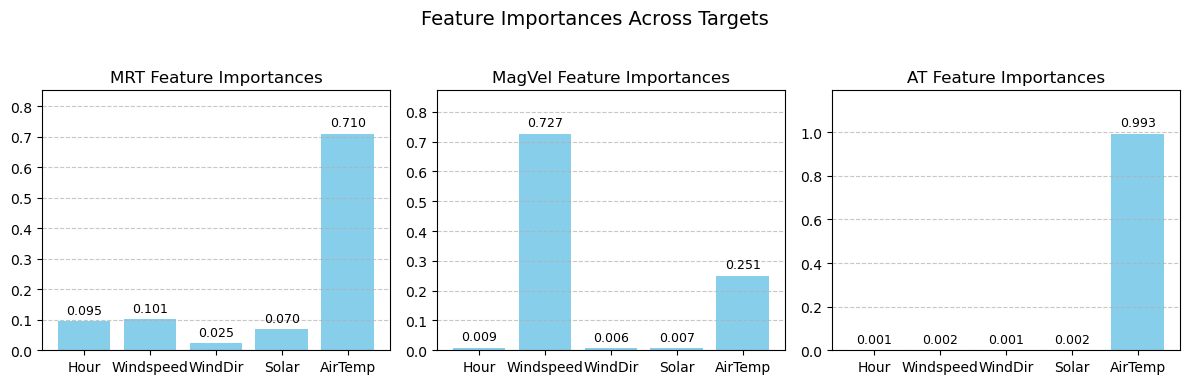

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# === FEATURE IMPORTANCE DISPLAY WITH PLOTS IN A SINGLE ROW ===
feature_names = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
targets = ["MRT", "MagVel", "AT"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # A4-friendly width

for idx, target in enumerate(targets):
    print(f"\nFeature importances for {target}:")
    importances = final_models[target].estimators_[0].feature_importances_
    for feat, imp in zip(feature_names, importances):
        print(f"{feat}: {imp:.3f}")

    # Plot
    bars = axs[idx].bar(feature_names, importances, color="skyblue")
    axs[idx].set_title(f"{target} Feature Importances", fontsize=12)
    axs[idx].set_ylim(0, max(importances) * 1.2)
    axs[idx].grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate bars
    for bar, imp in zip(bars, importances):
        height = bar.get_height()
        axs[idx].annotate(f"{imp:.3f}",
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom', fontsize=9)

# Layout adjustments
plt.suptitle("Feature Importances Across Targets", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

# Evaluate Day and Nighttime Testing Results

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def compute_metrics(flat_true, flat_pred):
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))
    return r2, mae, rmse

# === SPLIT TEST SET INTO DAYTIME AND NIGHTTIME BASED ON SOLAR IRRADIANCE ===
solar_test = X_test[:, 3]  # Solar Irradiance column (index 3)
day_indices = np.where(solar_test > 0)[0]
night_indices = np.where(solar_test == 0)[0]

print(f"🌞 Daytime test samples: {len(day_indices)}")
print(f"🌙 Nighttime test samples: {len(night_indices)}")

# === METRIC STORAGE ===
metrics_summary = {
    "MRT": {"day": {}, "night": {}},
    "MagVel": {"day": {}, "night": {}},
    "AT": {"day": {}, "night": {}}
}

# === METRIC CALCULATION ===
for target in ["MRT", "MagVel", "AT"]:
    pca_model = PCA_models_current[target]
    y_test = Y_pca_data_test_current[target]
    model = final_models[target]

    def process_subset(indices):
        flat_true_list = []
        flat_pred_list = []

        for i in indices:
            true_pca = y_test[i]
            pred_pca = model.predict(X_test[i].reshape(1, -1))[0]

            true_img = pca_model.inverse_transform(true_pca).reshape(1000, 1000)
            pred_img = pca_model.inverse_transform(pred_pca).reshape(1000, 1000)

            nan_mask = true_img == 0
            true_img[nan_mask] = np.nan
            pred_img[nan_mask] = np.nan

            valid = ~np.isnan(true_img)
            flat_true_list.append(true_img[valid])
            flat_pred_list.append(pred_img[valid])

        flat_true_all = np.concatenate(flat_true_list)
        flat_pred_all = np.concatenate(flat_pred_list)
        return flat_true_all, flat_pred_all

    # Daytime Metrics
    day_flat_true, day_flat_pred = process_subset(day_indices)
    r2_day, mae_day, rmse_day = compute_metrics(day_flat_true, day_flat_pred)
    metrics_summary[target]["day"] = {"R²": r2_day, "MAE": mae_day, "RMSE": rmse_day}

    # Nighttime Metrics
    night_flat_true, night_flat_pred = process_subset(night_indices)
    r2_night, mae_night, rmse_night = compute_metrics(night_flat_true, night_flat_pred)
    metrics_summary[target]["night"] = {"R²": r2_night, "MAE": mae_night, "RMSE": rmse_night}

    # Optional Print
    print(f"\n--- {target} ---")
    print(f"🌞 Day:  R²={r2_day:.3f}, MAE={mae_day:.3f}, RMSE={rmse_day:.3f}")
    print(f"🌙 Night: R²={r2_night:.3f}, MAE={mae_night:.3f}, RMSE={rmse_night:.3f}")

🌞 Daytime test samples: 24
🌙 Nighttime test samples: 20

--- MRT ---
🌞 Day:  R²=0.716, MAE=1.444, RMSE=2.311
🌙 Night: R²=0.953, MAE=0.820, RMSE=1.219

--- MagVel ---
🌞 Day:  R²=0.944, MAE=0.192, RMSE=0.286
🌙 Night: R²=0.941, MAE=0.071, RMSE=0.101

--- AT ---
🌞 Day:  R²=0.994, MAE=0.341, RMSE=0.445
🌙 Night: R²=0.996, MAE=0.291, RMSE=0.354


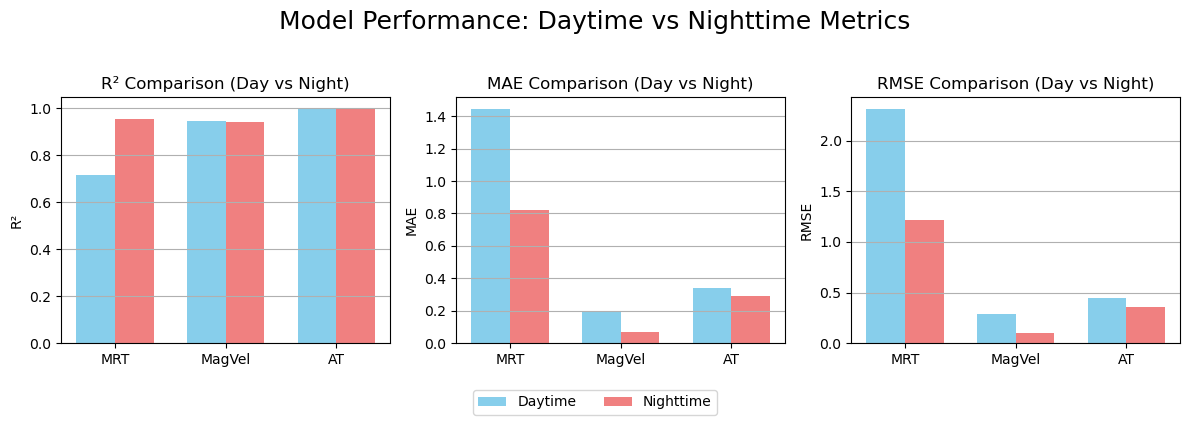

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# === BAR PLOTS ===
metrics = ["R²", "MAE", "RMSE"]
targets = ["MRT", "MagVel", "AT"]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

bar_handles = []

for idx, metric in enumerate(metrics):
    day_vals = [metrics_summary[t]["day"][metric] for t in targets]
    night_vals = [metrics_summary[t]["night"][metric] for t in targets]

    x = np.arange(len(targets))
    width = 0.35

    bars_day = axs[idx].bar(x - width/2, day_vals, width, label="Daytime", color="skyblue")
    bars_night = axs[idx].bar(x + width/2, night_vals, width, label="Nighttime", color="lightcoral")

    # Capture bar handles for shared legend
    if idx == 0:
        bar_handles = [bars_day[0], bars_night[0]]

    axs[idx].set_ylabel(metric)
    axs[idx].set_title(f"{metric} Comparison (Day vs Night)")
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(targets)
    axs[idx].grid(True, axis='y')

# Add shared legend below the subplots
fig.legend(bar_handles, ["Daytime", "Nighttime"], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Model Performance: Daytime vs Nighttime Metrics", fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space for legend
plt.show()

# Save Model Parameters 

In [26]:
import joblib
import numpy as np

# === DETERMINE CORRECT PCA MODEL SOURCE ===
PCA_models_to_save = PCA_models_bal if use_balanced else PCA_models_unbal

# === SAVE FINAL MODELS AND PCA MODELS ===
for target in ["MRT", "MagVel", "AT"]:
    # Use the final models (which includes GB for MRT)
    joblib.dump(final_models[target], f"{target}_final_model.pkl", compress=3)
    joblib.dump(PCA_models_to_save[target], f"{target}_pca.pkl", compress=9)

# === SAVE SCALER INPUTS (if needed) ===
np.save("X_features_minmax.npy", [X_features.min(axis=0), X_features.max(axis=0)])

# Plot results

Selected sample indices: [10 18  7  8 42]

Sample 1
  Hour:               7
  Windspeed [m/s]:    2.00
  Wind Dir [deg]:     309
  Solar Irrad [W/m²]: 105
  Air Temp [K]:       292.65


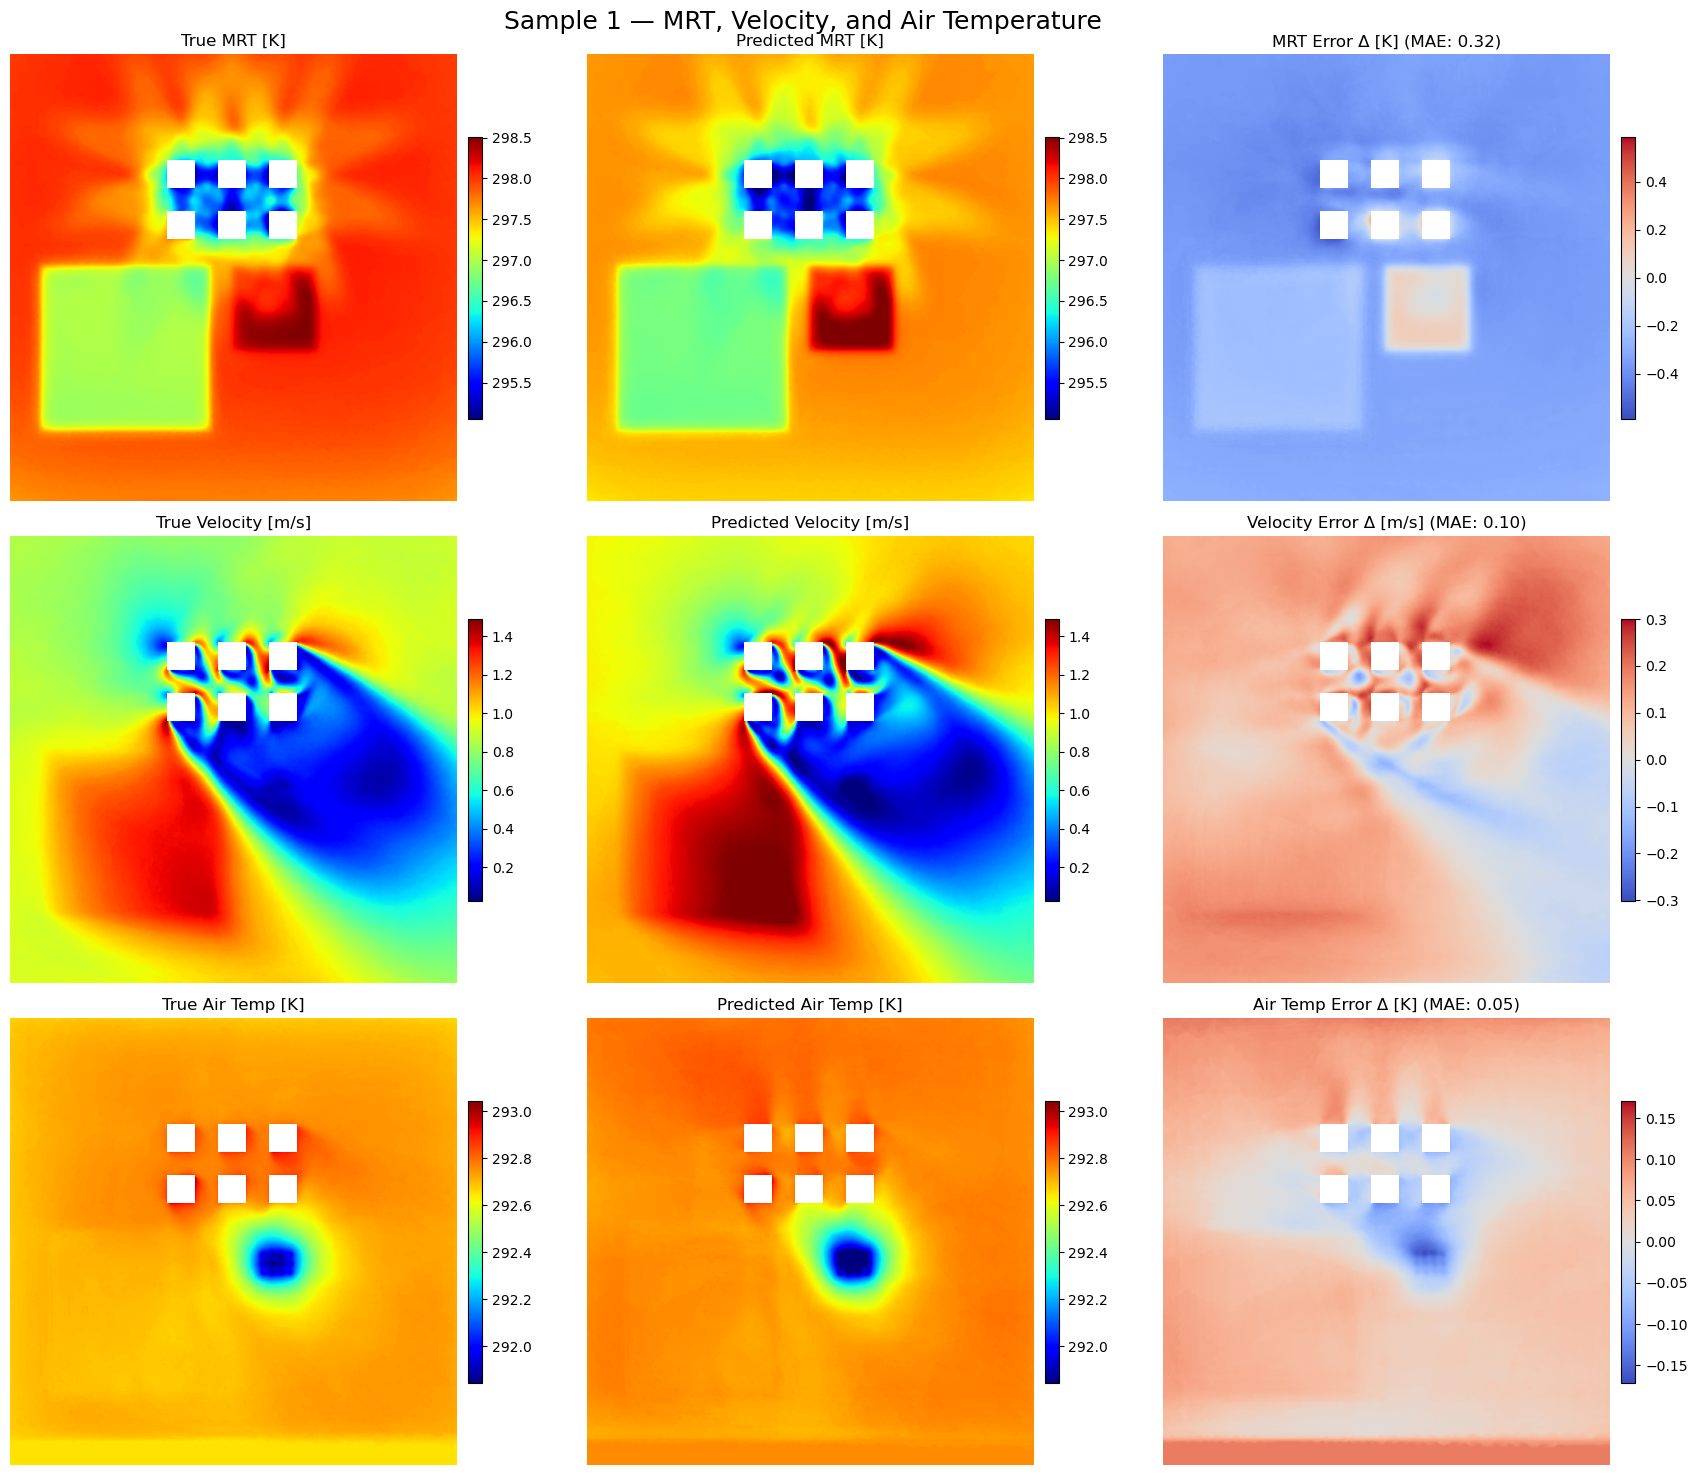


Sample 2
  Hour:               22
  Windspeed [m/s]:    1.61
  Wind Dir [deg]:     99
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       295.15


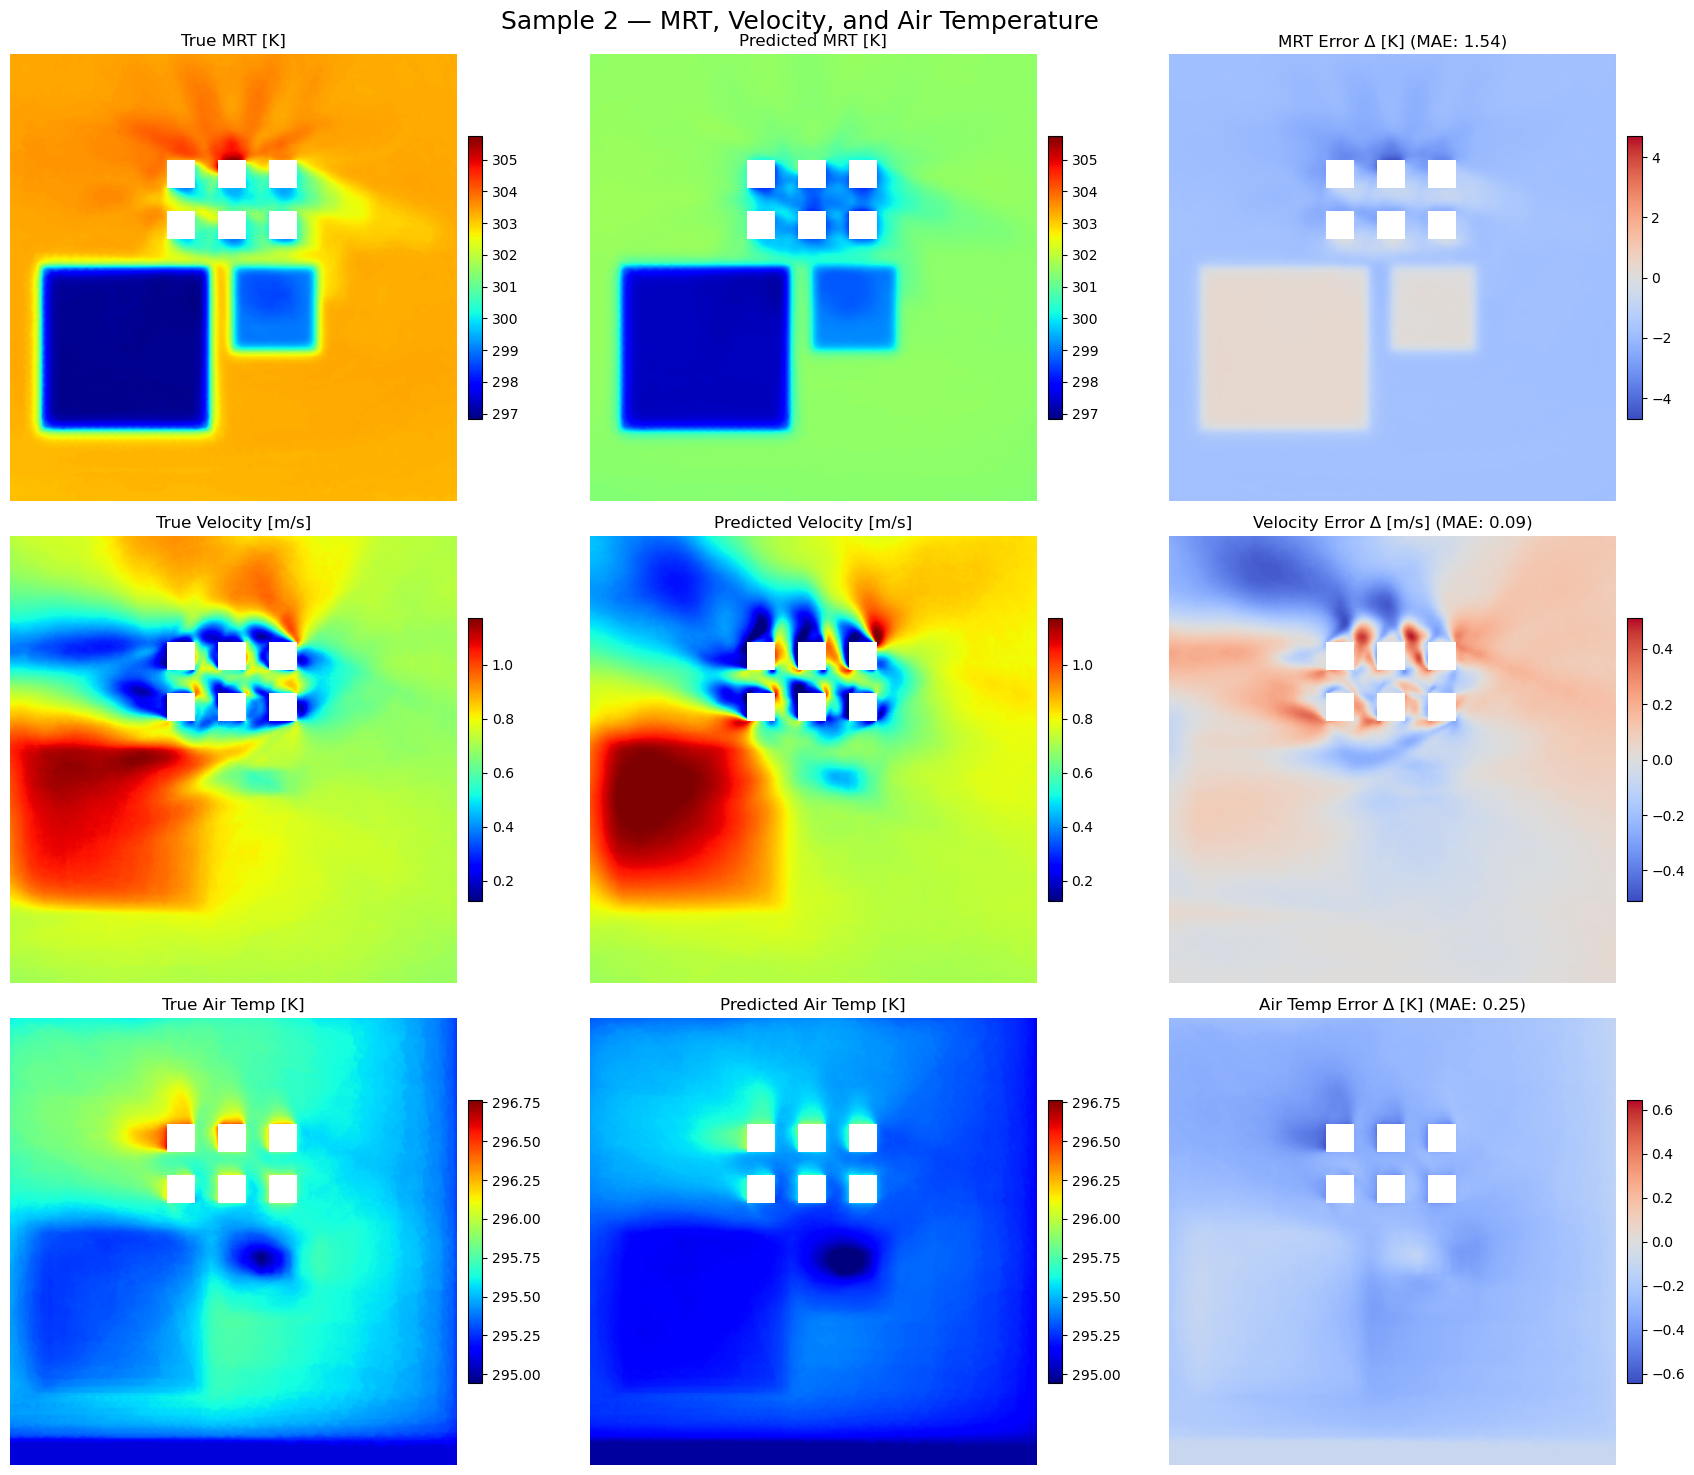


Sample 3
  Hour:               5
  Windspeed [m/s]:    2.81
  Wind Dir [deg]:     56
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       297.65


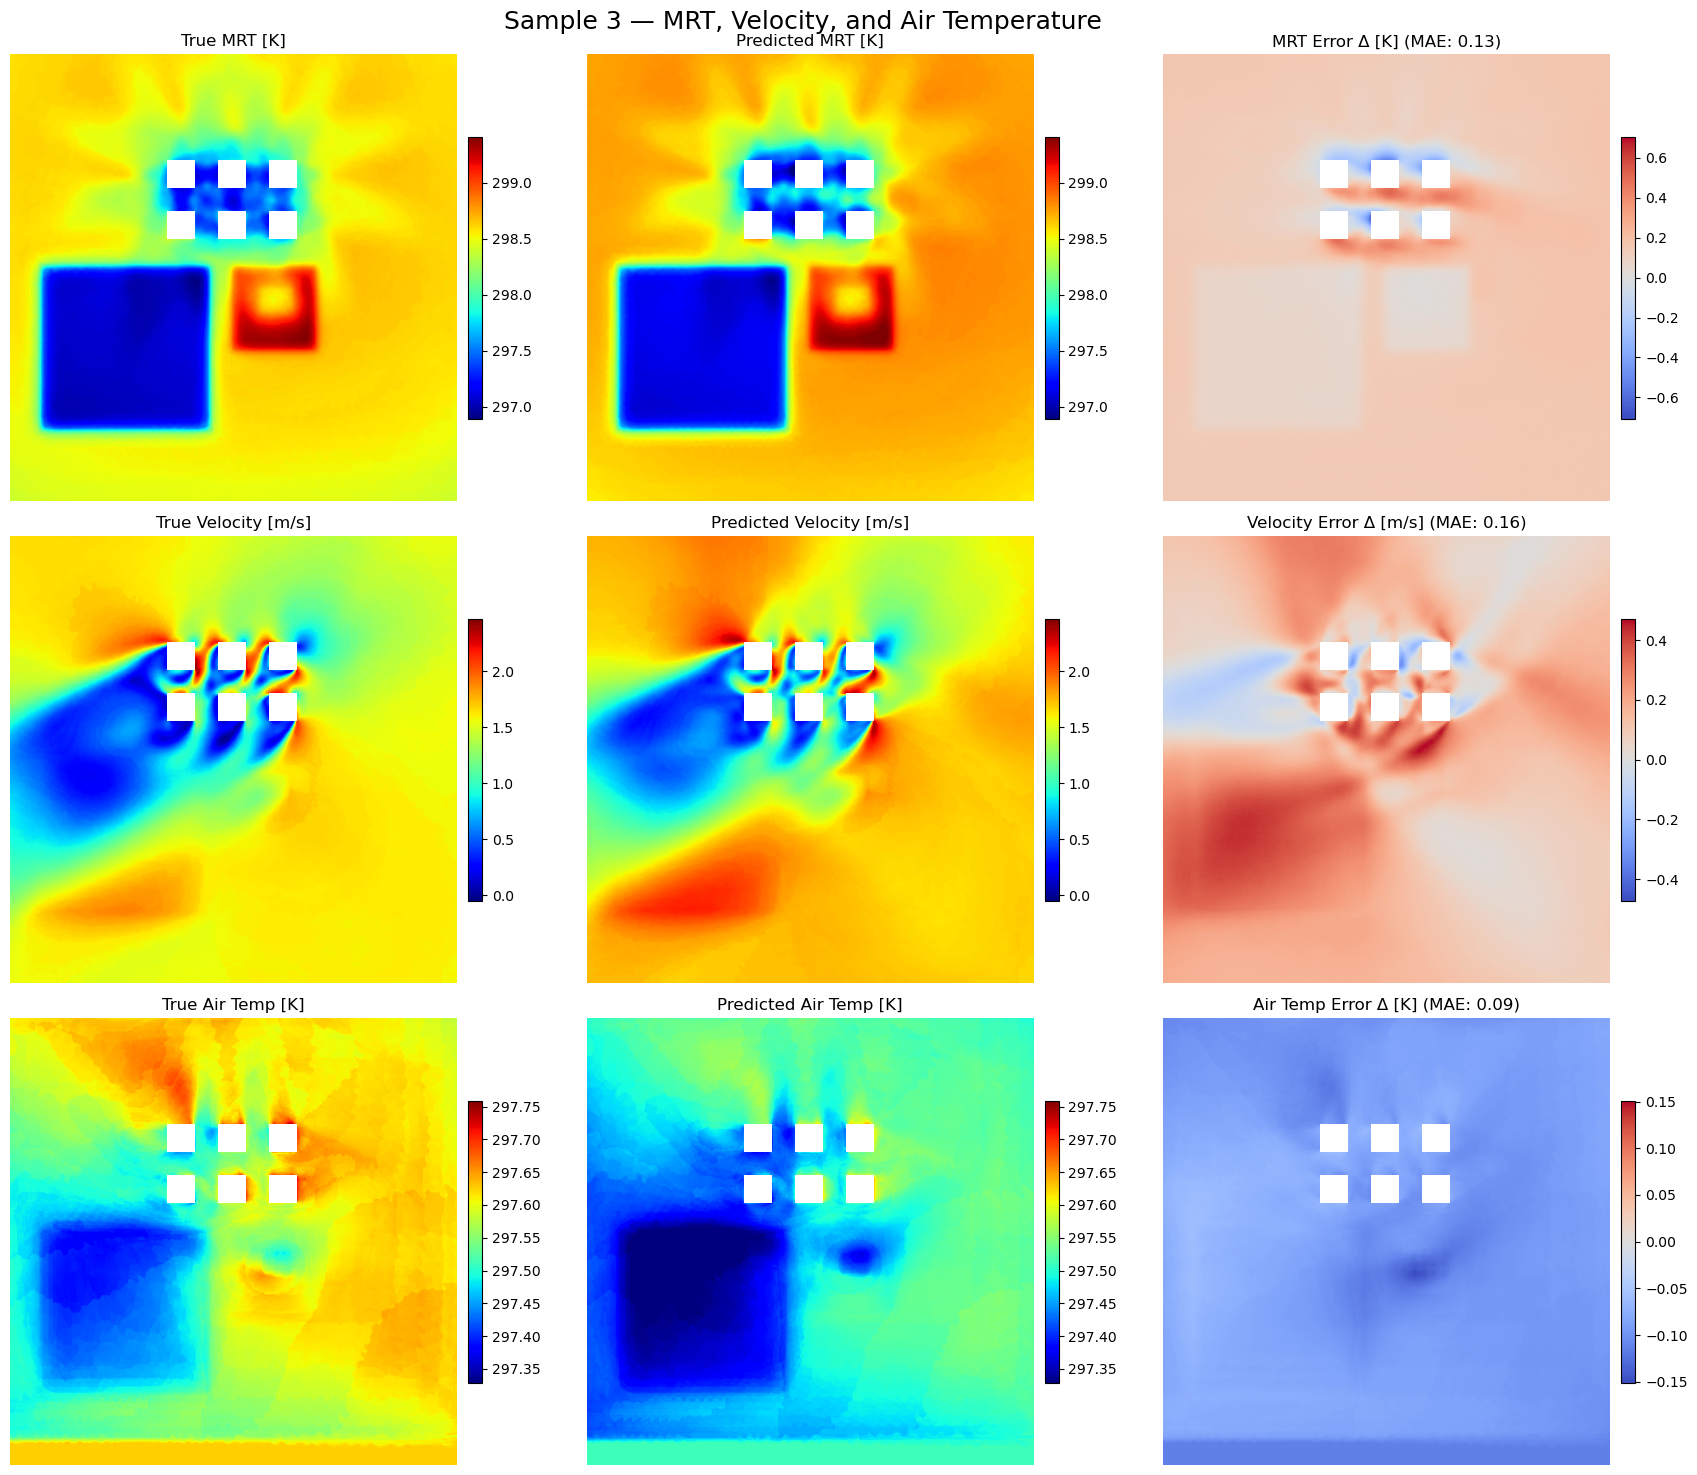


Sample 4
  Hour:               6
  Windspeed [m/s]:    0.81
  Wind Dir [deg]:     334
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       286.95


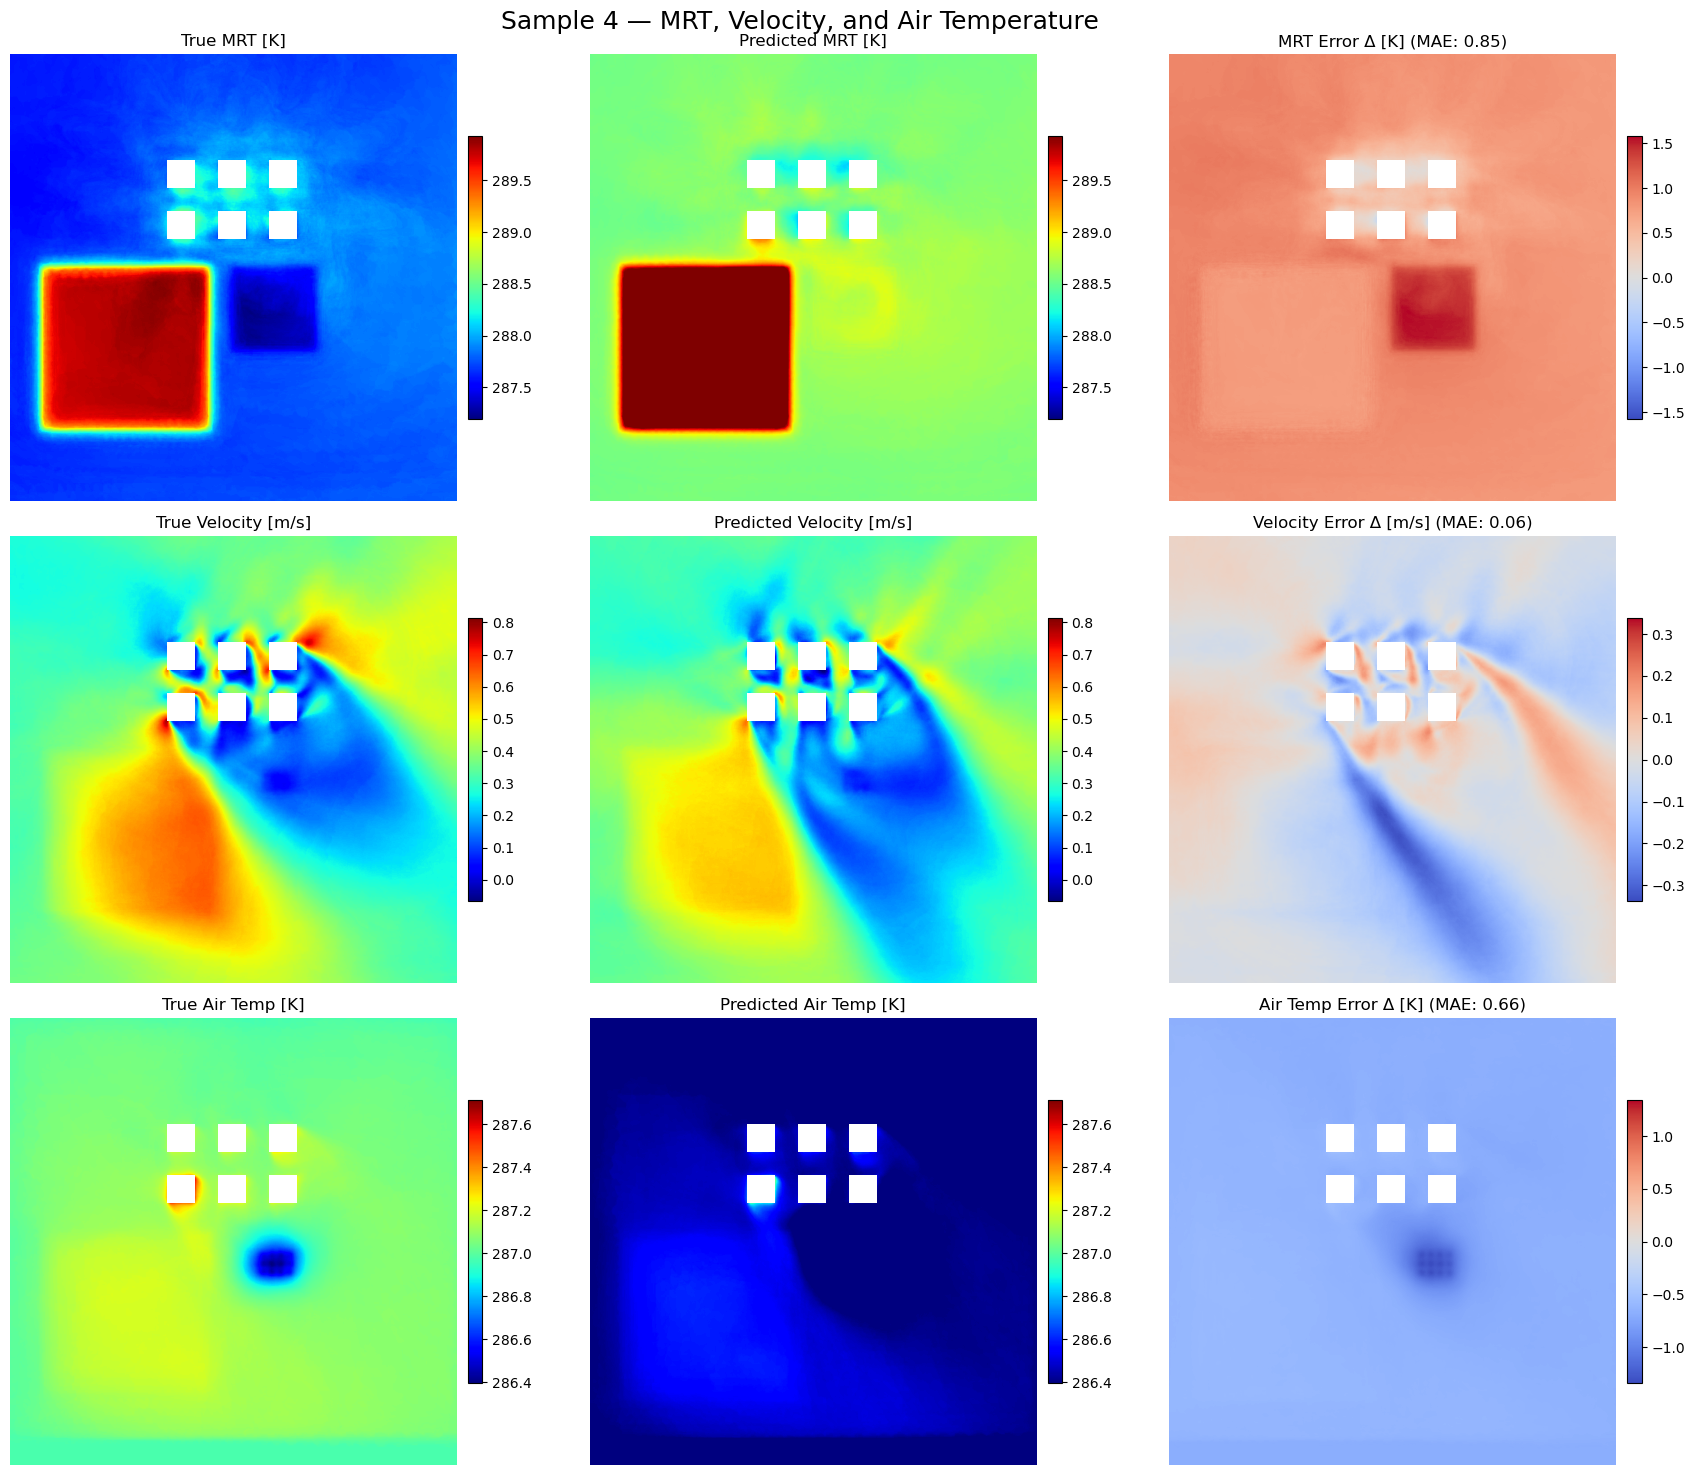


Sample 5
  Hour:               12
  Windspeed [m/s]:    2.69
  Wind Dir [deg]:     211
  Solar Irrad [W/m²]: 811
  Air Temp [K]:       296.85


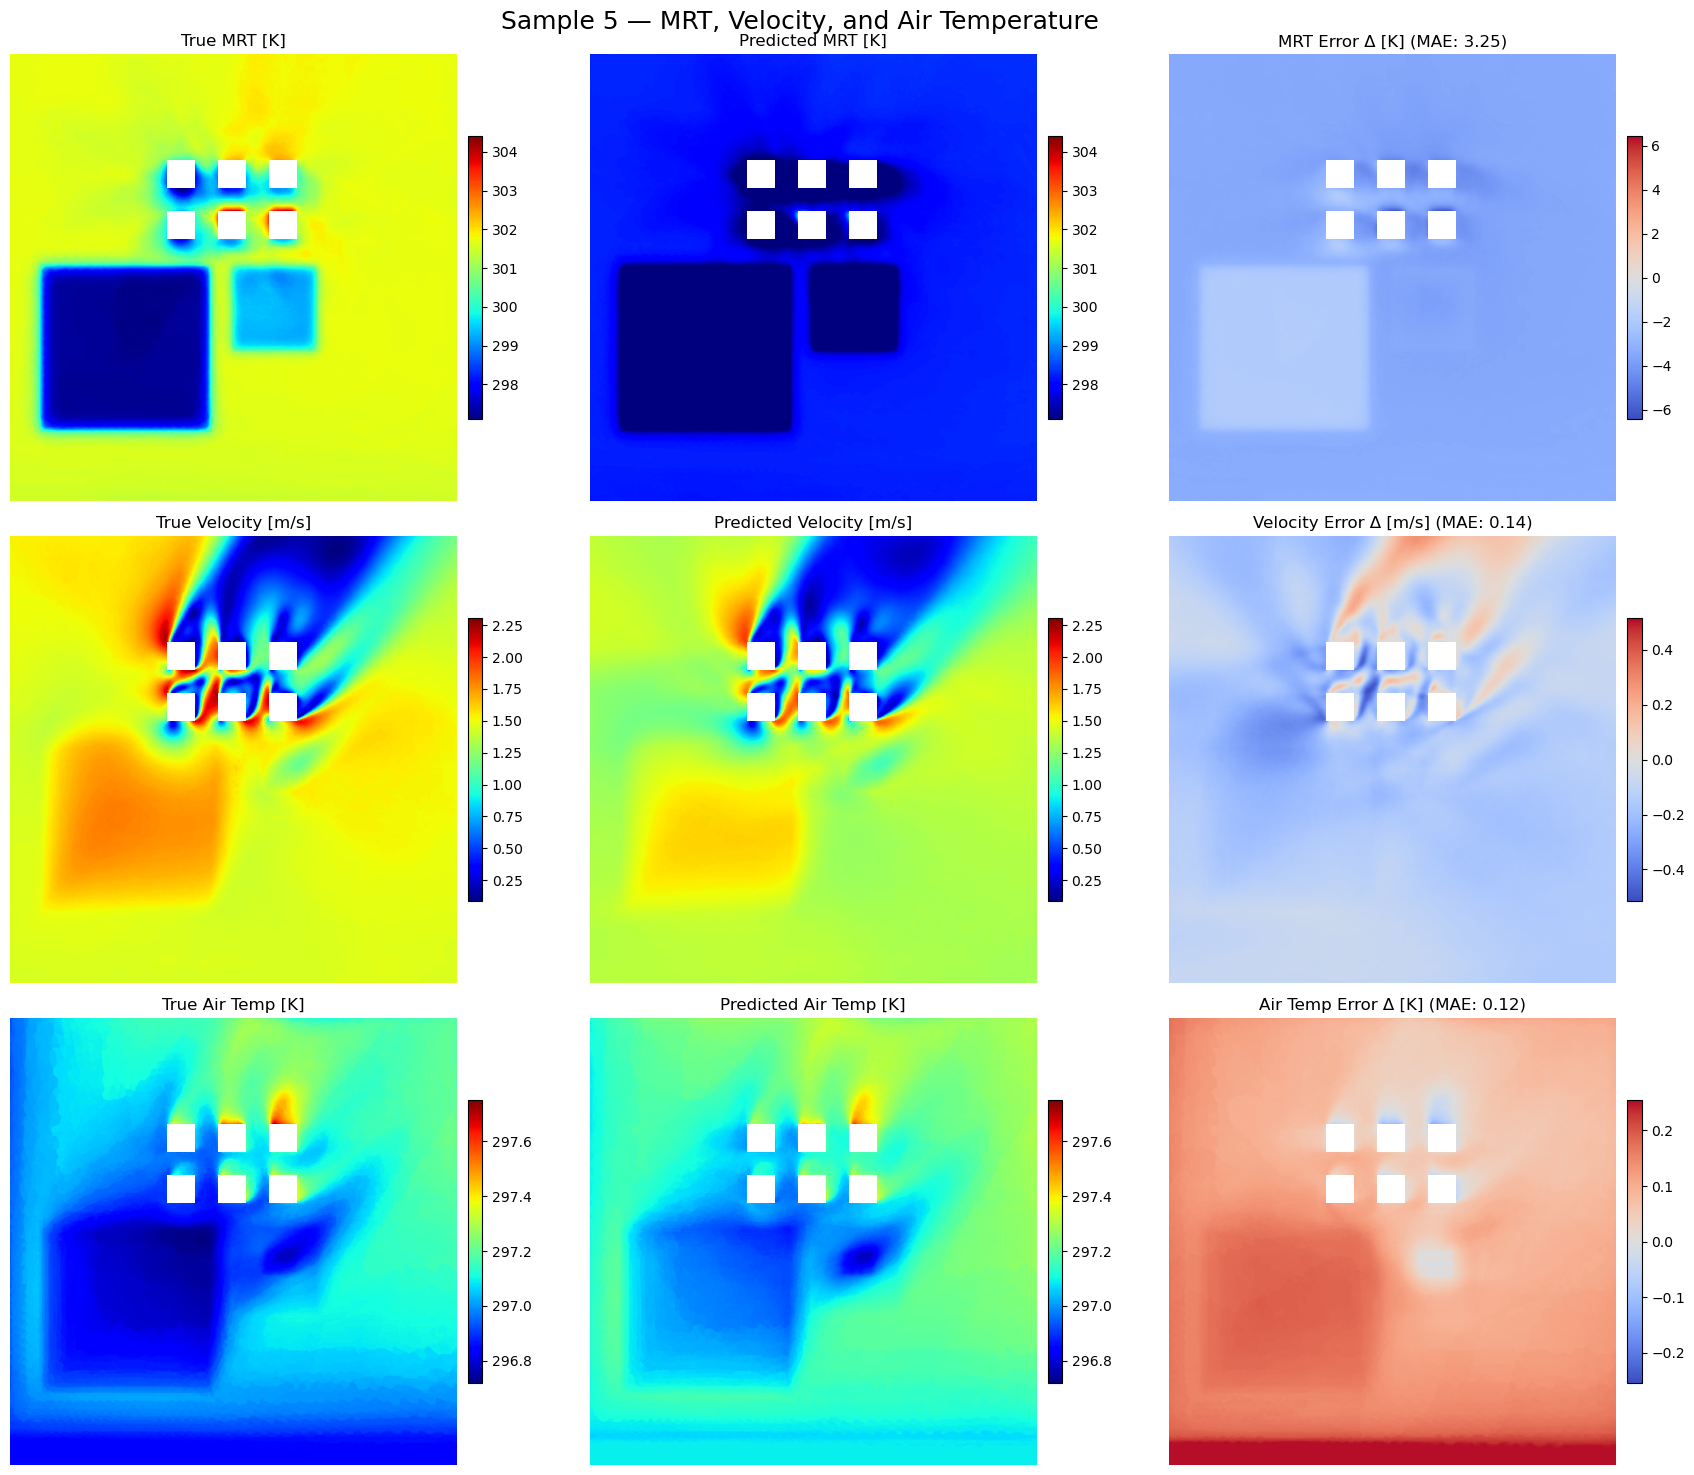

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Select PCA models based on dataset toggle
pca_models_test = PCA_models_bal if use_balanced else PCA_models_unbal

# Sample 5 random test indices
n_samples = 5
rand_indices = np.random.choice(len(X_test), size=n_samples, replace=False)
print(f"Selected sample indices: {rand_indices}")

for idx, i in enumerate(rand_indices):
    input_features = X_test[i]

    def reconstruct_and_mask(target):
        true_pca = Y_pca_data_test_current[target][i]
        pred_pca = final_models[target].predict(input_features.reshape(1, -1))[0]

        pca_model_test = pca_models_test[target]

        true_img = pca_model_test.inverse_transform(true_pca).reshape(1000, 1000)
        pred_img = pca_model_test.inverse_transform(pred_pca).reshape(1000, 1000)
        error_img = pred_img - true_img

        nan_mask = (true_img == 0)
        true_img[nan_mask] = np.nan
        pred_img[nan_mask] = np.nan
        error_img[nan_mask] = np.nan

        return true_img, pred_img, error_img

    # Reconstruct each target
    true_mrt, pred_mrt, err_mrt = reconstruct_and_mask("MRT")
    true_vel, pred_vel, err_vel = reconstruct_and_mask("MagVel")
    true_at, pred_at, err_at = reconstruct_and_mask("AT")

    # Print input features
    print(f"\nSample {idx + 1}")
    print(f"  Hour:               {input_features[0]:.0f}")
    print(f"  Windspeed [m/s]:    {input_features[1]:.2f}")
    print(f"  Wind Dir [deg]:     {input_features[2]:.0f}")
    print(f"  Solar Irrad [W/m²]: {input_features[3]:.0f}")
    print(f"  Air Temp [K]:       {input_features[4]:.2f}")

    # Create figure with 3 rows and 3 columns
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    # --- MRT row ---
    vmin, vmax = np.nanmin(true_mrt), np.nanmax(true_mrt)
    axs[0, 0].imshow(true_mrt, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0, 0].set_title("True MRT [K]")
    plt.colorbar(axs[0, 0].images[0], ax=axs[0, 0], fraction=0.025, pad=0.02)

    axs[0, 1].imshow(pred_mrt, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0, 1].set_title("Predicted MRT [K]")
    plt.colorbar(axs[0, 1].images[0], ax=axs[0, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_mrt))
    mae_mrt = np.nanmean(np.abs(err_mrt))
    axs[0, 2].imshow(err_mrt, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[0, 2].set_title(f"MRT Error Δ [K] (MAE: {mae_mrt:.2f})")
    plt.colorbar(axs[0, 2].images[0], ax=axs[0, 2], fraction=0.025, pad=0.02)

    # --- Velocity row ---
    vmin, vmax = np.nanmin(true_vel), np.nanmax(true_vel)
    axs[1, 0].imshow(true_vel, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1, 0].set_title("True Velocity [m/s]")
    plt.colorbar(axs[1, 0].images[0], ax=axs[1, 0], fraction=0.025, pad=0.02)

    axs[1, 1].imshow(pred_vel, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1, 1].set_title("Predicted Velocity [m/s]")
    plt.colorbar(axs[1, 1].images[0], ax=axs[1, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_vel))
    mae_vel = np.nanmean(np.abs(err_vel))
    axs[1, 2].imshow(err_vel, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[1, 2].set_title(f"Velocity Error Δ [m/s] (MAE: {mae_vel:.2f})")
    plt.colorbar(axs[1, 2].images[0], ax=axs[1, 2], fraction=0.025, pad=0.02)

    # --- Air Temperature row ---
    vmin, vmax = np.nanmin(true_at), np.nanmax(true_at)
    axs[2, 0].imshow(true_at, cmap="jet", vmin=vmin, vmax=vmax)
    axs[2, 0].set_title("True Air Temp [K]")
    plt.colorbar(axs[2, 0].images[0], ax=axs[2, 0], fraction=0.025, pad=0.02)

    axs[2, 1].imshow(pred_at, cmap="jet", vmin=vmin, vmax=vmax)
    axs[2, 1].set_title("Predicted Air Temp [K]")
    plt.colorbar(axs[2, 1].images[0], ax=axs[2, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_at))
    mae_at = np.nanmean(np.abs(err_at))
    axs[2, 2].imshow(err_at, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[2, 2].set_title(f"Air Temp Error Δ [K] (MAE: {mae_at:.2f})")
    plt.colorbar(axs[2, 2].images[0], ax=axs[2, 2], fraction=0.025, pad=0.02)

    # Remove axis ticks
    for ax in axs.ravel():
        ax.axis("off")

    plt.suptitle(f"Sample {idx + 1} — MRT, Velocity, and Air Temperature", fontsize=18)
    plt.tight_layout()
    plt.show()

# Visualize Error per Input Variable

In [36]:
# --- Track MAE per sample for all targets ---
mae_all = {"MRT": [], "MagVel": [], "AT": []}
input_features_all = {"MRT": [], "MagVel": [], "AT": []}

# Use PCA models matching training dataset toggle
pca_models_test = PCA_models_bal if use_balanced else PCA_models_unbal

for target in ["MRT", "MagVel", "AT"]:
    pca_model = pca_models_test[target]
    model = final_models[target]

    for i in range(len(X_test)):
        true_pca = Y_pca_data_test_current[target][i]
        pred_pca = model.predict(X_test[i].reshape(1, -1))[0]

        true_img = pca_model.inverse_transform(true_pca).reshape(1000, 1000)
        pred_img = pca_model.inverse_transform(pred_pca).reshape(1000, 1000)
        error_img = pred_img - true_img

        nan_mask = (true_img == 0)
        error_img[nan_mask] = np.nan

        mae = np.nanmean(np.abs(error_img))

        # Store per sample
        mae_all[target].append(mae)
        input_features_all[target].append(X_test[i])

    mae_all[target] = np.array(mae_all[target])
    input_features_all[target] = np.array(input_features_all[target])



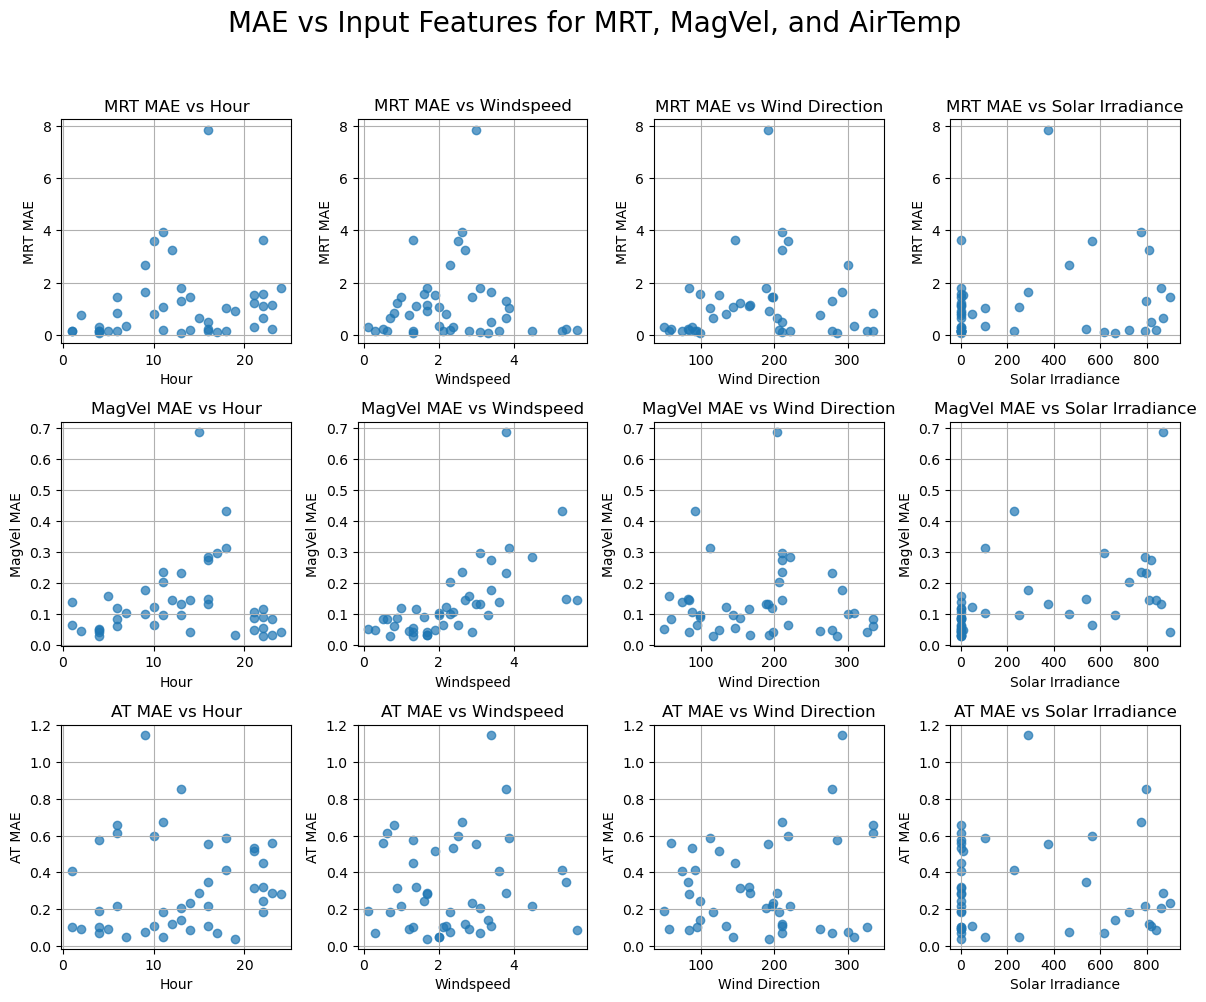

In [37]:
# --- Plot MAE vs Inputs for all targets ---
import matplotlib.pyplot as plt

feature_labels = ["Hour", "Windspeed", "Wind Direction", "Solar Irradiance"]
targets = ["MRT", "MagVel", "AT"]
fig, axs = plt.subplots(len(targets), 4, figsize=(12, 3.5 * len(targets)))

for t_idx, target in enumerate(targets):
    for f_idx in range(4):  # Skip AirTemp input (index 4) for plotting
        axs[t_idx, f_idx].scatter(input_features_all[target][:, f_idx], mae_all[target], alpha=0.7)
        axs[t_idx, f_idx].set_xlabel(feature_labels[f_idx])
        axs[t_idx, f_idx].set_ylabel(f"{target} MAE")
        axs[t_idx, f_idx].set_title(f"{target} MAE vs {feature_labels[f_idx]}")
        axs[t_idx, f_idx].grid(True)

plt.suptitle("MAE vs Input Features for MRT, MagVel, and AirTemp", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
# === Print training ranges ===
X_arr = np.array(X_features)
input_names = ["Hour", "Windspeed (m/s)", "Wind Dir (deg)", "Solar Irrad (W/m²)", "Air Temp (K)"]
print("\n📊 Training Data Ranges:")

for i, name in enumerate(input_names):
    min_val = np.min(X_arr[:, i])
    max_val = np.max(X_arr[:, i])
    print(f"  {name:>25}: {min_val:.2f} to {max_val:.2f}")




📊 Training Data Ranges:
                       Hour: 1.00 to 24.00
            Windspeed (m/s): 0.11 to 6.31
             Wind Dir (deg): 3.00 to 353.00
         Solar Irrad (W/m²): 0.00 to 973.00
               Air Temp (K): 279.95 to 310.05


# Summary: 
### Baseline Model: Random Forest with PCA

We trained a MultiOutput Random Forest Regressor for each target field (MRT, Air Temp, and Velocity) using PCA-compressed outputs.

**Why RF?**
- Handles nonlinear relationships effectively (5values to eg mrt is a nonlinear correlation)
- Robust to overfitting with samall datasets, handle nonlinearity.
- No need to standardize with RF models (decision trees implement thresholds obased on absolute values, and therefore dont need standaridze values)

**Why PCA?**
- Each output image contains 1 million pixels; direct training on this high-dimensional output is computationally too expensive
- PCA reduces each image to 20 components, capturing the majority of variance with minimal information loss

**Strengths:**
- Interpretable baseline with clear metric tracking
- Fast to train and evaluate
- GridSearchCV applied for hyperparameter tuning

**Limitations:**
- Ignores spatial structure in climate fields
- Can't generalize well to out-of-distribution inputs (beyond what is given as both training and testing. Testing looks okay, but beyond that, poor job of generalization)
- Not physically constrained (Can return unrealistic Fields)
- Potential overfitting with limited training data (~240 samples)

**Next:** 

- Nonlinear predictor that uses spatial and physical constraints (CNN based Auto Encoder with physical loss function (eg mass flow conservation) and meauserement data)


**Issues that persist:**

- The relative error to the input data is fairly high ( eg windspeed input at 1.2m/s and errors show +- 0.4m/s)
- Random split for training and testing acorss all hours.  maybe not so good approach. Action: run simulations separately from the 12 days for validation, as the full 12 days are strategically selected to give the model varied training data. 


Discussion Augustin: 
- Use Distance Map and Feate